<a href="https://colab.research.google.com/github/DavidKNam/Hotel-Review-Deception/blob/master/Hotel_Review_Deception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detecting Deception within Online Hotel Reviews**


**Downgrade Tensorflow**



*   Some components below rely on the previous version of Tensorflow and the following line must be executed before proceeding





In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Mount Drive

Dataset can be found from Kaggle:
*   https://www.kaggle.com/rtatman/deceptive-opinion-spam-corpus

Pre-Trained Word Embeddings can be found:

*   GloVe: https://nlp.stanford.edu/projects/glove/
*   FastText: https://fasttext.cc/docs/en/english-vectors.html
*   Word2Vec: https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/





In [ ]:
from google.colab import drive
try:
  drive.mount('/content/drive')
  print("Mounting Google Drive Successful")
except:
  print("Mounting Google Drive Failed")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mounting Google Drive Successful


## Load Libraries

In [ ]:
import io
import spacy
import re
import math
import codecs
import gensim

import pandas as pd
import gensim.parsing.preprocessing as gsp
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from gensim import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import auc, roc_auc_score, roc_curve
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dropout, MaxPooling1D, LSTM, Dense, Masking, Embedding, Bidirectional, Flatten, TimeDistributed, MaxPooling1D

## Prepare Data

**Load Dataset**

In [ ]:
# Load Dataset
hotel_review_df = pd.read_csv('/content/drive/My Drive/deceptive-opinion.csv')

print("Number of Records: {}".format(hotel_review_df.shape[0]))

# Finding the sentence with the most amount of words
text_length = {
    "lengths" : []
}
for sentence in hotel_review_df['text'].values:
  length = 0
  length = len(sentence.split())
  text_length['lengths'].append(length)
text_length_df = pd.DataFrame(text_length)
hotel_review_df = pd.concat([hotel_review_df, text_length_df], axis=1)

print("Largest Word Count in Text: {}".format(hotel_review_df['lengths'].max()))
print("Average Word Count in Text: {}".format(hotel_review_df['lengths'].mean()))
print("Median Word Count in Text: {}".format(hotel_review_df['lengths'].median()))

Number of Records: 1600
Largest Word Count in Text: 784
Average Word Count in Text: 148.775
Median Word Count in Text: 128.0


**Encode Deceptive Labels**

Label Mapping


*   Truthful: 1 
*   Deceptive: 0



In [ ]:
le = LabelEncoder()
hotel_review_df['deceptive'] = le.fit_transform(hotel_review_df['deceptive'])
hotel_review_df

deceptive  ... lengths
0             1  ...     105
1             1  ...      45
2             1  ...     207
3             1  ...     127
4             1  ...      72
...         ...  ...     ...
1595          0  ...     131
1596          0  ...     121
1597          0  ...     141
1598          0  ...      86
1599          0  ...     260

[1600 rows x 6 columns]

**Preprocess Text**


In [ ]:
filters = [
                  gsp.strip_tags, 
                  gsp.strip_punctuation, 
                  gsp.strip_multiple_whitespaces, 
                  gsp.strip_numeric
                  ]

url_regex = re.compile(r'http(s)?://(w{3}\.)?(([\w\-_]+\.)+\w{1,6})(/[\w&$\-_.+!*\'()?=#;%:~,]*)*|'
                    r'http:?(/){0,2}\S*$')

# Using both Gensim and Spacy to clean text
# Gensim to clean unnecessary characters
# Spacy to Lemmatize: Using "en_core_web_sm" - Genre: Written Text (Blogs, news, comments)

def clean_str(text):
  lem = spacy.load('en_core_web_sm')
  texts = []
  text = re.sub(url_regex, "", text)
  text = " ".join(gsp.preprocess_string(text, filters))
  for x in lem(text):
    if x.lemma_ != '-PRON-':
      texts.append(x.lemma_)
    else:
      texts.append(x.text)
  text = " ".join(texts)
  return text

hotel_review_df['text'] = hotel_review_df['text'].map(clean_str)

print("Complete")

Complete


**Tokenize Text**

In [ ]:
# Size of Vocab is 5000 (Common practice, can change)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(hotel_review_df['text'])

text = tokenizer.texts_to_sequences(hotel_review_df['text'])

# Add one due to 0 being reserved for padding
vocab_size = len(tokenizer.word_index) + 1 

# Determined by the average of words in texts (Can change)
maxlen = hotel_review_df['lengths'].max()
# maxlen = math.ceil(hotel_review_df['lengths'].mean())

text = pad_sequences(text, padding='post', maxlen=maxlen)

print("Complete")

Using TensorFlow backend.


Complete


**Pre-Trained Word Embedding and Early Stopping**

In [ ]:
embedding_dim = 300

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

# GloVe
embedding_matrix_glove = create_embedding_matrix('/content/drive/My Drive/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

# Word2Vec
matrix_word = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin', binary=True)  
words_not_found = []
vocabulary_size=min(10000, len(tokenizer.word_index))
embedding_matrix_word = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  if i>=vocabulary_size:
      continue
  try:
      embedding_vector = matrix_word[word]
      embedding_matrix_word[i] = embedding_vector
  except KeyError:
      embedding_matrix_word[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)

# FastText
embeddings_index = {}
f = codecs.open('/content/drive/My Drive/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
words_not_found = []
nb_words = min(10000, len(tokenizer.word_index))
embedding_matrix_fasttext = np.zeros((nb_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix_fasttext[i] = embedding_vector
    else:
        words_not_found.append(word)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
999995it [01:31, 10892.96it/s]


**Setup Functions for Precision, Recall, F1**

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def confusion_matrix(y_true, y_pred):
  matrix = metrics.confusion_matrix(y_true, y_pred)
  return matrix

**Function to Display Performance**

In [ ]:
def model_performance(model, performance):
  pyplot.title('Model Loss')
  plt.plot(performance.history['loss'])
  plt.plot(performance.history['val_loss'])
  pyplot.ylabel('Loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.title('Model Accuracy')
  pyplot.plot(performance.history['acc'])
  pyplot.plot(performance.history['val_acc'])
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'val'], loc='upper left')
  pyplot.show()
    
  #ROC
    
  # Predict probabilities and generate a no skill prediction (majority class)
  ns_probs = [0 for _ in range(len(test_y))]
  lr_probs = model.predict_proba(test_X)

  ns_auc = roc_auc_score(test_y, ns_probs)
  lr_auc = roc_auc_score(test_y, lr_probs)

  # Summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Model: ROC AUC=%.3f' % (lr_auc))

  # Calculate ROC curves
  ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)

  # Plot the ROC curve for the model
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
  pyplot.title("Receiver Operating Characteristic")

  # Axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
    
  # Show the legend
  pyplot.legend()

  pyplot.show()

  auc_keras = auc(lr_fpr, lr_tpr)
  print(auc_keras)

**K-Fold Function for Models**

In [ ]:
def k_fold_model(model, k_folds=10):

  cv = KFold(n_splits=k_folds, random_state=42, shuffle=True)

  result = []
  for train_index, test_index in cv.split(text):
    train_X = text[train_index]
    test_X = text[test_index]
    train_y = hotel_review_df['deceptive'].iloc[train_index]
    test_y = hotel_review_df['deceptive'].iloc[test_index] 

    performance = model.fit(train_X, train_y,
                        epochs=20,
                        callbacks=[early_stopping],
                        validation_split=0.2,
                        batch_size=32)

    result.append(model.evaluate(test_X, test_y, verbose=1))
    test_y_predict = model.predict_classes(test_X)
    print(confusion_matrix(test_y, test_y_predict))

    model_performance(model, performance)

  results = [sum(i)/k_folds for i in zip(*result)] 
  print(results)

## Artificial Neural Networks (ANNs)

### Convolutional Neural Network (CNN)

#### **CNN without WE**





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 782, 128)          115328    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
T

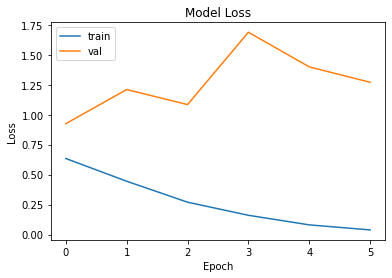

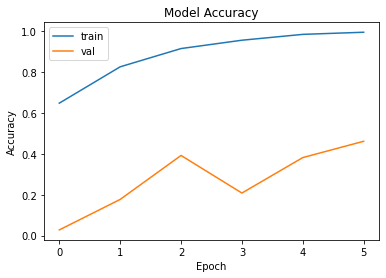

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.803


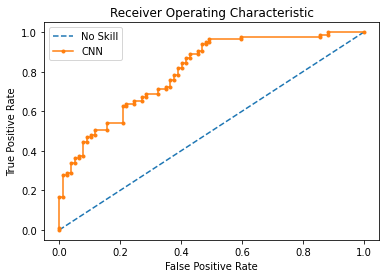

0.8030042246909717
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 372us/step - loss: 0.4934 - acc: 0.7986 - precision_m: 0.7819 - recall_m: 0.9532 - f1_m: 0.8533 - val_loss: 0.9257 - val_acc: 0.3090 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 378us/step - loss: 0.3139 - acc: 0.9062 - precision_m: 0.9113 - recall_m: 0.9425 - f1_m: 0.9254 - val_loss: 1.4015 - val_acc: 0.1562 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 356us/step - loss: 0.1704 - acc: 0.9531 - precision_m: 0.9526 - recall_m: 0.9717 - f1_m: 0.9610 - val_loss: 1.2237 - val_acc: 0.3681 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 359us/step - loss: 0.0817 - acc: 0.9844 - precision_m: 0.98

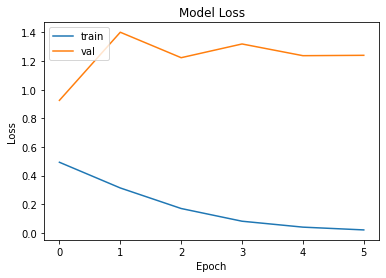

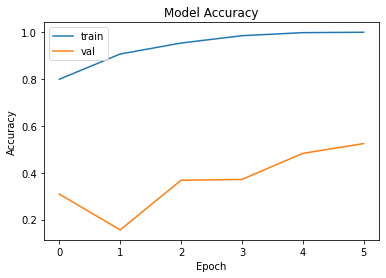

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.895


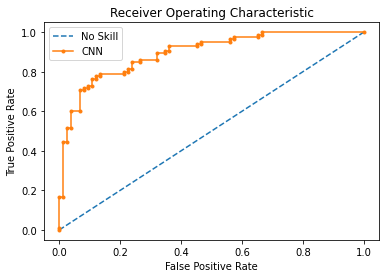

0.8949019607843137
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 372us/step - loss: 0.3290 - acc: 0.8845 - precision_m: 0.8917 - recall_m: 0.9361 - f1_m: 0.9104 - val_loss: 1.5727 - val_acc: 0.1250 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 363us/step - loss: 0.1894 - acc: 0.9453 - precision_m: 0.9457 - recall_m: 0.9700 - f1_m: 0.9563 - val_loss: 1.2853 - val_acc: 0.3333 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 373us/step - loss: 0.0749 - acc: 0.9887 - precision_m: 0.9866 - recall_m: 0.9961 - f1_m: 0.9911 - val_loss: 1.1146 - val_acc: 0.4410 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 381us/step - loss: 0.0350 - acc: 0.9983 - precision_m: 0.99

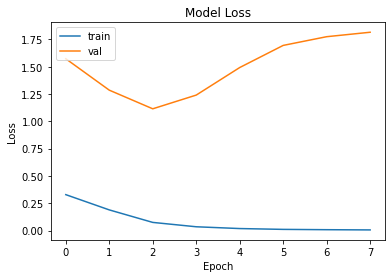

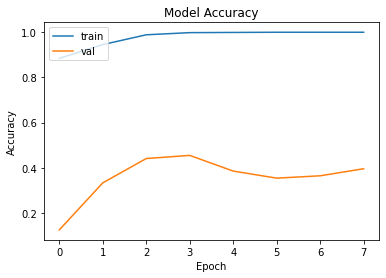

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.899


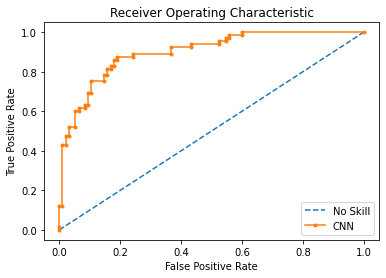

0.8992712550607287
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 365us/step - loss: 0.0739 - acc: 0.9792 - precision_m: 0.9839 - recall_m: 0.9844 - f1_m: 0.9836 - val_loss: 1.2683 - val_acc: 0.4375 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 364us/step - loss: 0.0262 - acc: 0.9991 - precision_m: 0.9984 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.5905 - val_acc: 0.3889 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 357us/step - loss: 0.0146 - acc: 0.9991 - precision_m: 0.9984 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.6316 - val_acc: 0.4236 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 362us/step - loss: 0.0099 - acc: 1.0000 - precision_m: 1.00

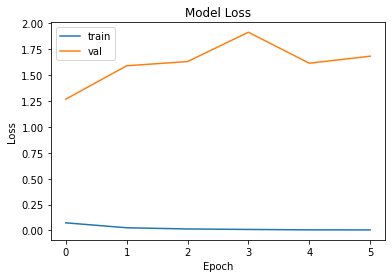

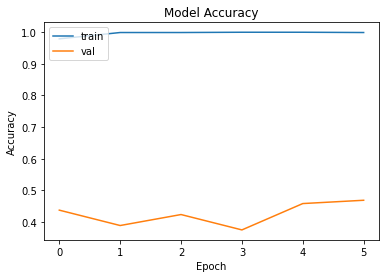

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.982


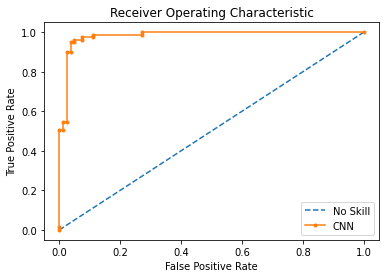

0.9824972651976871
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 368us/step - loss: 0.0342 - acc: 0.9931 - precision_m: 0.9944 - recall_m: 0.9948 - f1_m: 0.9945 - val_loss: 1.6022 - val_acc: 0.3472 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 364us/step - loss: 0.0172 - acc: 0.9983 - precision_m: 0.9988 - recall_m: 0.9983 - f1_m: 0.9985 - val_loss: 1.7508 - val_acc: 0.3542 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 356us/step - loss: 0.0084 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1057 - val_acc: 0.3056 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 369us/step - loss: 0.0049 - acc: 1.0000 - precision_m: 1.00

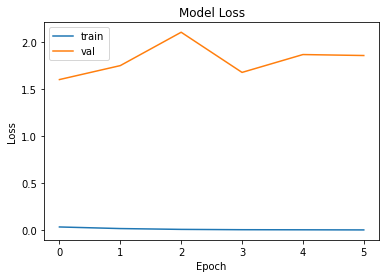

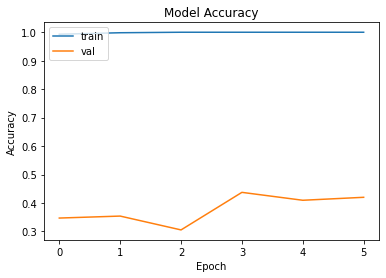

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.981


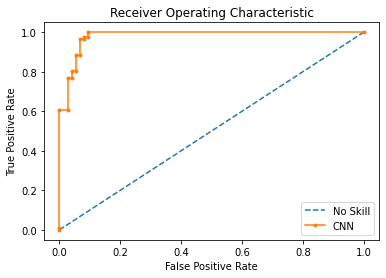

0.9811439346323068
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 356us/step - loss: 0.0286 - acc: 0.9922 - precision_m: 0.9943 - recall_m: 0.9929 - f1_m: 0.9934 - val_loss: 1.0985 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 374us/step - loss: 0.0152 - acc: 0.9983 - precision_m: 0.9987 - recall_m: 0.9985 - f1_m: 0.9986 - val_loss: 1.5031 - val_acc: 0.4688 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 389us/step - loss: 0.0074 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.2804 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 369us/step - loss: 0.0043 - acc: 1.0000 - precision_m: 1.00

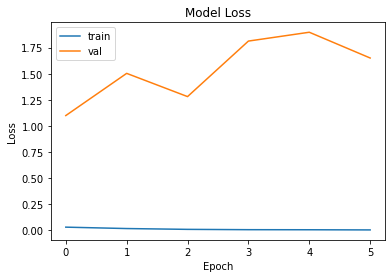

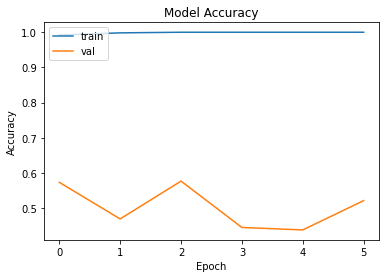

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.990


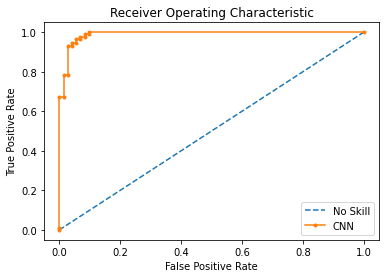

0.9897411616161617
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 374us/step - loss: 0.0117 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.3834 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 374us/step - loss: 0.0069 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.4520 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 370us/step - loss: 0.0043 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7075 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 363us/step - loss: 0.0027 - acc: 1.0000 - precision_m: 1.00

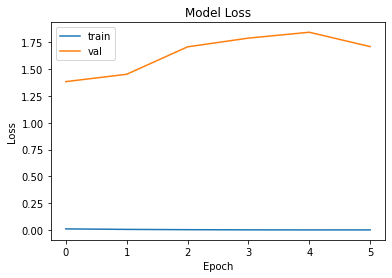

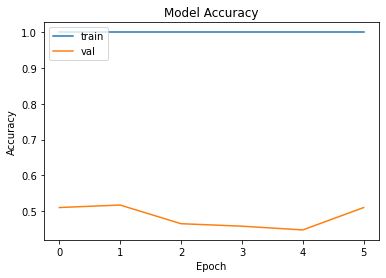

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.997


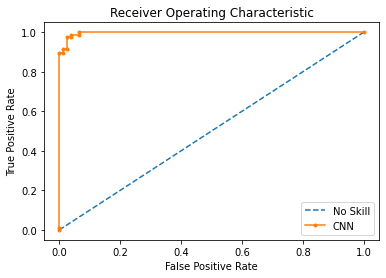

0.9968671679197996
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 376us/step - loss: 0.0087 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7339 - val_acc: 0.4271 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 372us/step - loss: 0.0057 - acc: 0.9991 - precision_m: 1.0000 - recall_m: 0.9985 - f1_m: 0.9992 - val_loss: 2.0574 - val_acc: 0.3715 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 372us/step - loss: 0.0040 - acc: 0.9991 - precision_m: 1.0000 - recall_m: 0.9986 - f1_m: 0.9993 - val_loss: 1.8504 - val_acc: 0.4618 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 393us/step - loss: 0.0039 - acc: 1.0000 - precision_m: 1.00

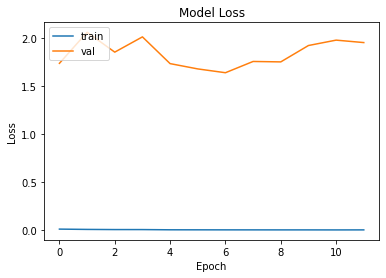

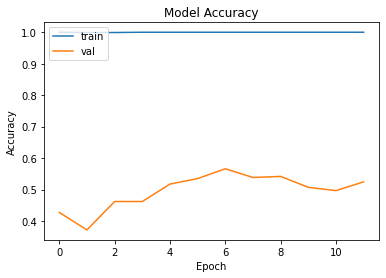

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.979


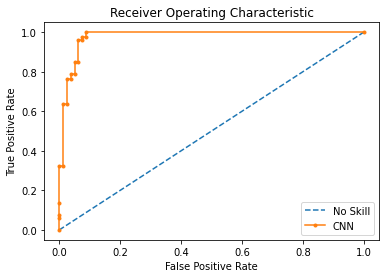

0.97875
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 370us/step - loss: 0.0019 - acc: 0.9991 - precision_m: 0.9983 - recall_m: 1.0000 - f1_m: 0.9991 - val_loss: 1.6357 - val_acc: 0.5660 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 361us/step - loss: 0.0014 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.4558 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 367us/step - loss: 8.1027e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1304 - val_acc: 0.4931 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 372us/step - loss: 0.0010 - acc: 1.0000 - precision_m: 1.0000 - re

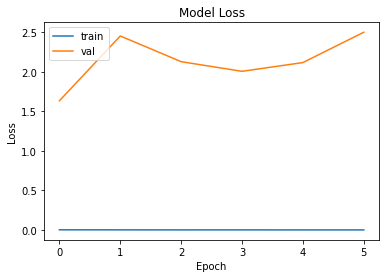

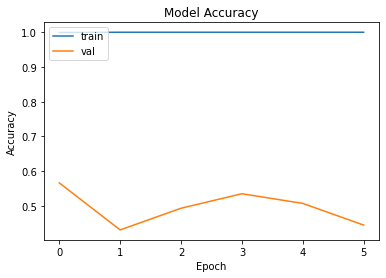

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.993


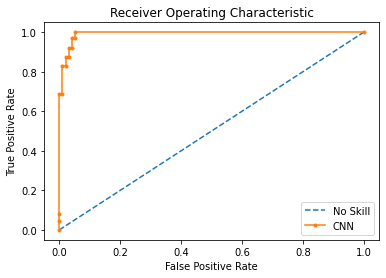

0.9925130208333333
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 376us/step - loss: 0.0011 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.3928 - val_acc: 0.4340 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 359us/step - loss: 9.4784e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.2457 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 370us/step - loss: 6.9557e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.0190 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 361us/step - loss: 5.5871e-04 - acc: 1.0000 - preci

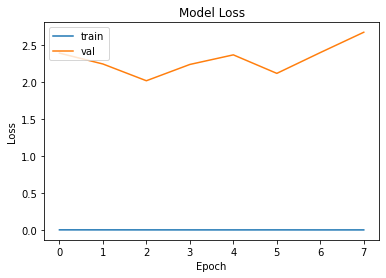

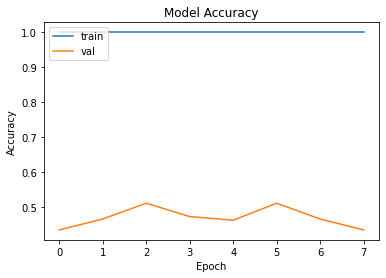

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.995


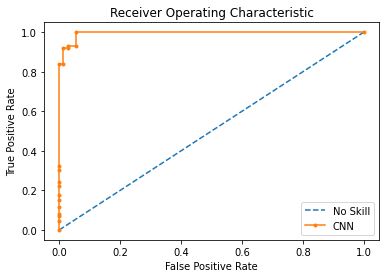

0.9948145820238844
[0.40108981166835295, 0.846875, 0.7160112646222114, 0.7672857689857482, 0.729262233376503]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **CNN with WE (word2vec)**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 782, 128)          115328    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,343,829
Trainable params: 2,343,829
Non-trainable params: 0
____________________________________________

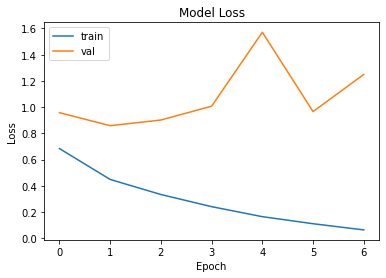

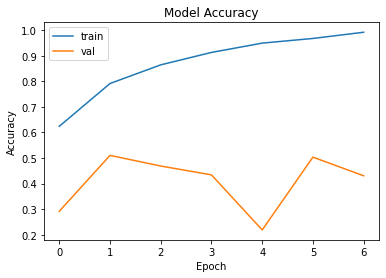

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.824


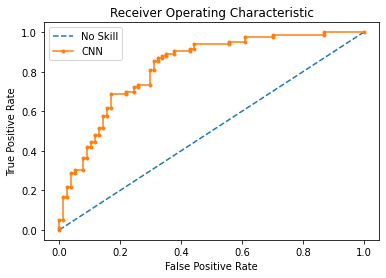

0.8244406196213425
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 361us/step - loss: 0.4144 - acc: 0.8160 - precision_m: 0.8532 - recall_m: 0.8766 - f1_m: 0.8530 - val_loss: 0.8983 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 373us/step - loss: 0.2629 - acc: 0.8984 - precision_m: 0.9021 - recall_m: 0.9431 - f1_m: 0.9192 - val_loss: 0.5879 - val_acc: 0.6701 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 363us/step - loss: 0.1686 - acc: 0.9514 - precision_m: 0.9627 - recall_m: 0.9615 - f1_m: 0.9604 - val_loss: 1.2124 - val_acc: 0.3924 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 357us/step - loss: 0.1015 - acc: 0.9774 - precision_m: 0.97

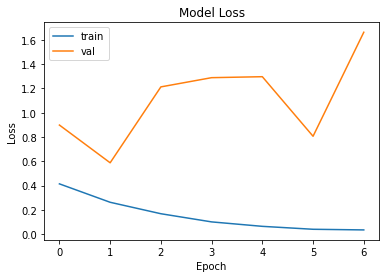

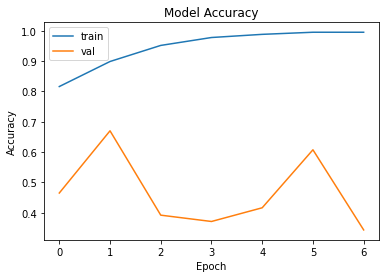

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.949


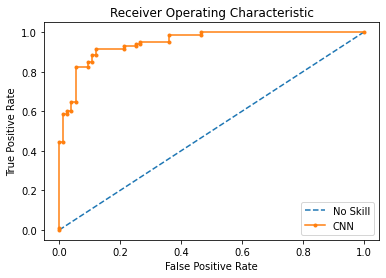

0.9494901960784314
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 367us/step - loss: 0.1721 - acc: 0.9470 - precision_m: 0.9506 - recall_m: 0.9667 - f1_m: 0.9569 - val_loss: 1.0022 - val_acc: 0.4722 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 365us/step - loss: 0.1019 - acc: 0.9757 - precision_m: 0.9767 - recall_m: 0.9849 - f1_m: 0.9802 - val_loss: 1.3640 - val_acc: 0.3924 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 374us/step - loss: 0.0596 - acc: 0.9861 - precision_m: 0.9862 - recall_m: 0.9923 - f1_m: 0.9888 - val_loss: 1.8140 - val_acc: 0.2743 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 389us/step - loss: 0.0463 - acc: 0.9913 - precision_m: 0.99

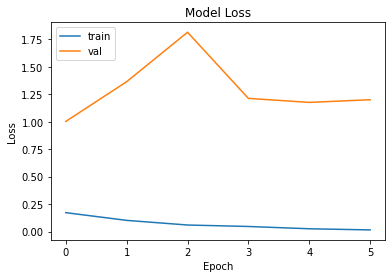

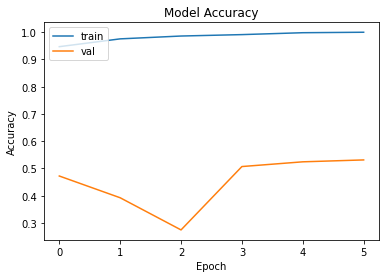

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.951


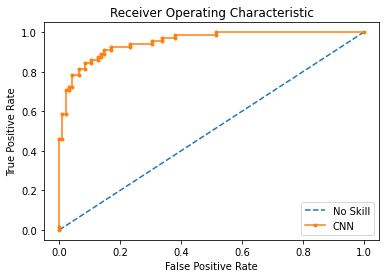

0.9507692307692308
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 383us/step - loss: 0.1318 - acc: 0.9601 - precision_m: 0.9694 - recall_m: 0.9682 - f1_m: 0.9674 - val_loss: 0.9009 - val_acc: 0.5417 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 362us/step - loss: 0.0796 - acc: 0.9800 - precision_m: 0.9813 - recall_m: 0.9873 - f1_m: 0.9838 - val_loss: 1.5876 - val_acc: 0.3160 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 389us/step - loss: 0.0403 - acc: 0.9948 - precision_m: 0.9971 - recall_m: 0.9939 - f1_m: 0.9954 - val_loss: 0.6998 - val_acc: 0.6597 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 361us/step - loss: 0.0231 - acc: 0.9991 - precision_m: 1.00

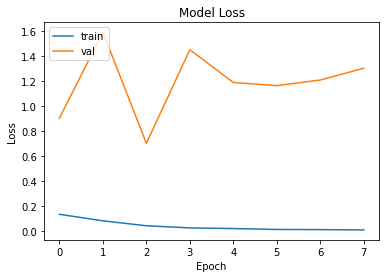

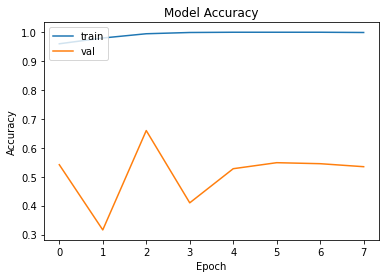

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.957


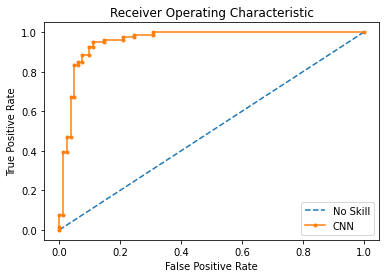

0.956868260665729
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 369us/step - loss: 0.0420 - acc: 0.9913 - precision_m: 0.9928 - recall_m: 0.9929 - f1_m: 0.9926 - val_loss: 1.1821 - val_acc: 0.5278 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 383us/step - loss: 0.0208 - acc: 0.9983 - precision_m: 0.9989 - recall_m: 0.9985 - f1_m: 0.9987 - val_loss: 1.1726 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 385us/step - loss: 0.0107 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5381 - val_acc: 0.4549 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 384us/step - loss: 0.0087 - acc: 1.0000 - precision_m: 1.000

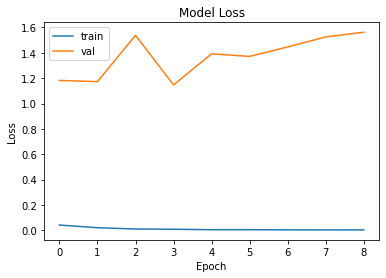

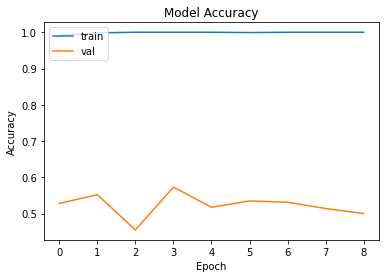

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.994


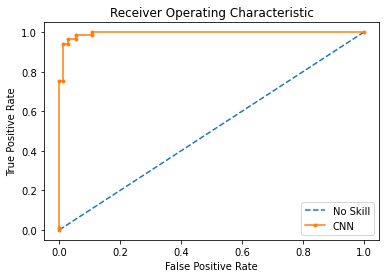

0.994343180389692
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 377us/step - loss: 0.0114 - acc: 0.9991 - precision_m: 0.9987 - recall_m: 1.0000 - f1_m: 0.9993 - val_loss: 1.2257 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 371us/step - loss: 0.0078 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.3870 - val_acc: 0.5139 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 385us/step - loss: 0.0052 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.1519 - val_acc: 0.5903 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 382us/step - loss: 0.0033 - acc: 1.0000 - precision_m: 1.000

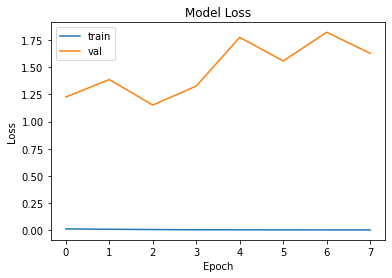

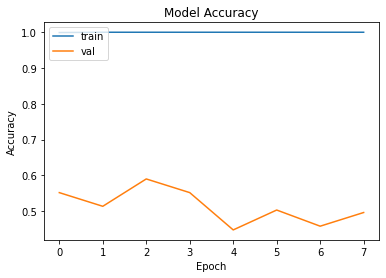

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.989


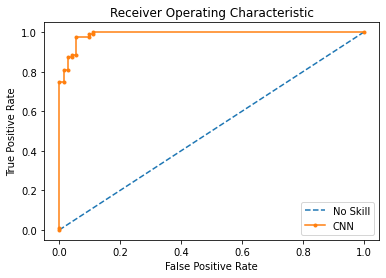

0.989425505050505
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 366us/step - loss: 0.0071 - acc: 0.9991 - precision_m: 1.0000 - recall_m: 0.9987 - f1_m: 0.9993 - val_loss: 2.3969 - val_acc: 0.3229 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 367us/step - loss: 0.0052 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7901 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 361us/step - loss: 0.0027 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5801 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 364us/step - loss: 0.0026 - acc: 1.0000 - precision_m: 1.000

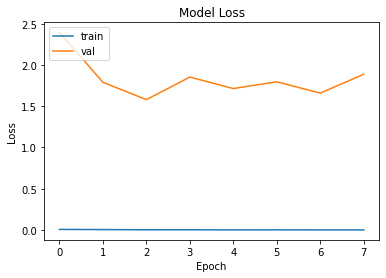

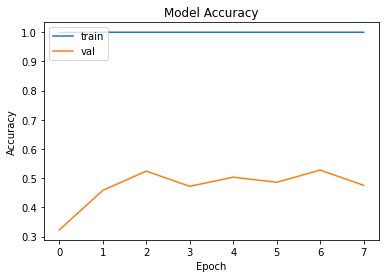

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.999


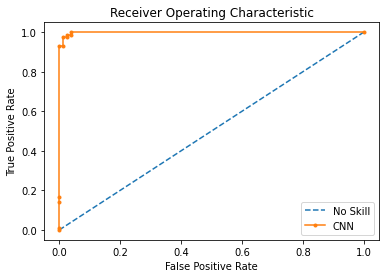

0.9985902255639098
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 379us/step - loss: 0.0024 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5690 - val_acc: 0.5451 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 373us/step - loss: 0.0021 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5289 - val_acc: 0.5590 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 378us/step - loss: 0.0015 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1459 - val_acc: 0.4236 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 373us/step - loss: 0.0022 - acc: 1.0000 - precision_m: 1.00

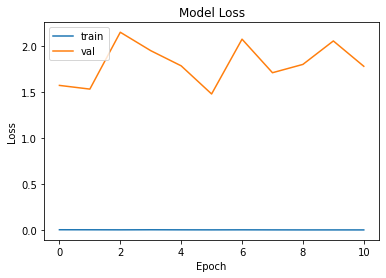

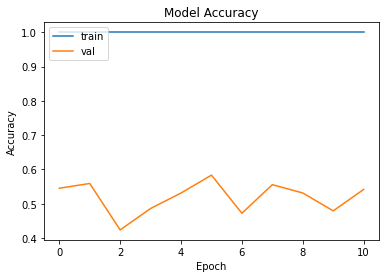

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.999


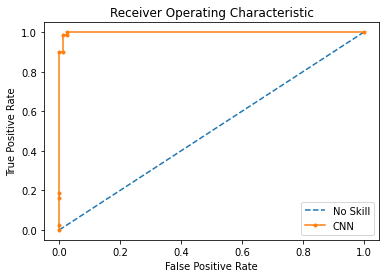

0.99859375
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 367us/step - loss: 9.4954e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8350 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 364us/step - loss: 8.5488e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8202 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 365us/step - loss: 6.9196e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8186 - val_acc: 0.5278 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 361us/step - loss: 7.6858e-04 - acc: 1.0000 - precision

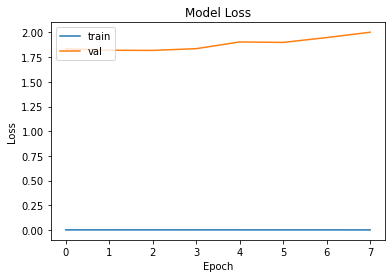

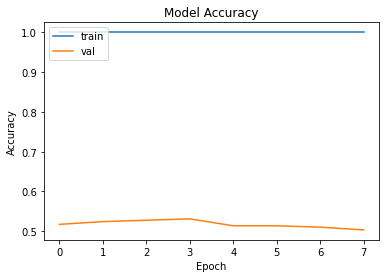

No Skill: ROC AUC=0.500
CNN: ROC AUC=1.000


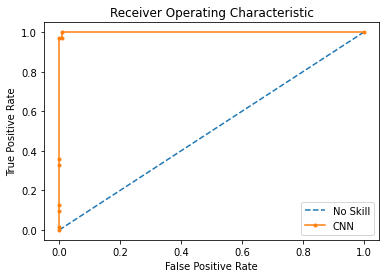

0.9996744791666667
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 367us/step - loss: 9.1452e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1000 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 383us/step - loss: 6.4782e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1433 - val_acc: 0.4514 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 373us/step - loss: 5.5227e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8294 - val_acc: 0.5208 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 361us/step - loss: 4.9590e-04 - acc: 1.0000 - p

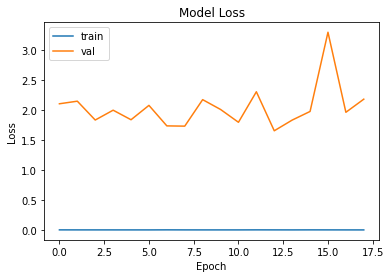

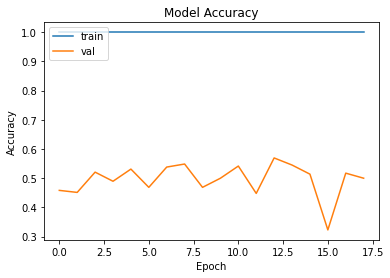

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.993


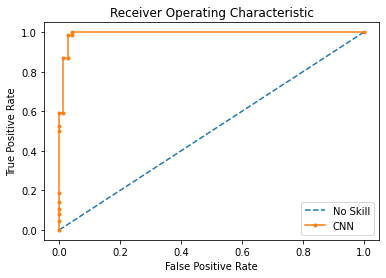

0.9926147077309868
[0.317453506913298, 0.8774999999999998, 0.731771245598793, 0.7565284049510955, 0.7352038913965224]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size - 1, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix_word]))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **CNN with WE (GloVe)**











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 782, 128)          115328    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11    

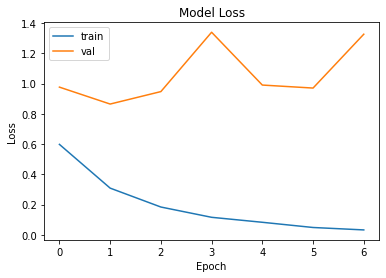

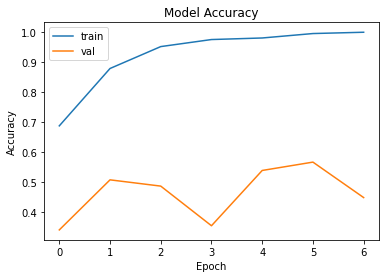

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.893


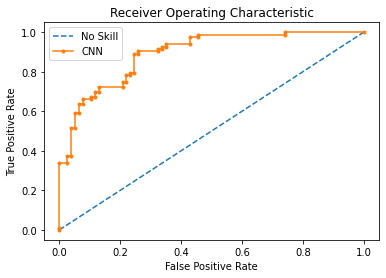

0.8926615553121577
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 322us/step - loss: 0.2383 - acc: 0.9184 - precision_m: 0.9288 - recall_m: 0.9459 - f1_m: 0.9344 - val_loss: 1.1881 - val_acc: 0.3715 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.1321 - acc: 0.9627 - precision_m: 0.9664 - recall_m: 0.9751 - f1_m: 0.9694 - val_loss: 1.0910 - val_acc: 0.4618 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 330us/step - loss: 0.0673 - acc: 0.9844 - precision_m: 0.9864 - recall_m: 0.9900 - f1_m: 0.9879 - val_loss: 1.2167 - val_acc: 0.4479 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 321us/step - loss: 0.0410 - acc: 0.9922 - precision_m: 0.99

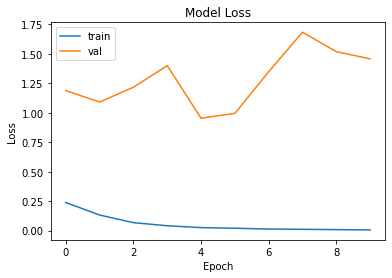

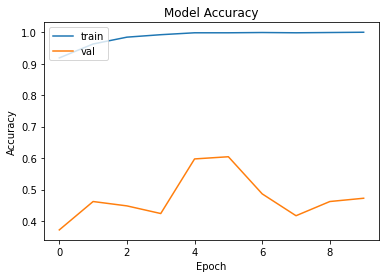

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.969


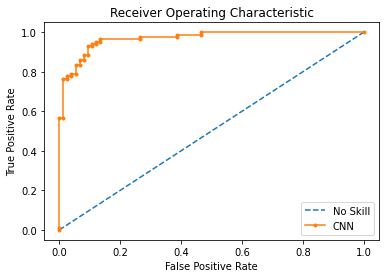

0.9687843137254901
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 318us/step - loss: 0.0462 - acc: 0.9870 - precision_m: 0.9923 - recall_m: 0.9880 - f1_m: 0.9898 - val_loss: 0.9850 - val_acc: 0.5938 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 310us/step - loss: 0.0166 - acc: 0.9991 - precision_m: 0.9988 - recall_m: 1.0000 - f1_m: 0.9994 - val_loss: 1.3833 - val_acc: 0.5000 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0114 - acc: 0.9991 - precision_m: 0.9985 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.6182 - val_acc: 0.4514 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.0070 - acc: 1.0000 - precision_m: 1.00

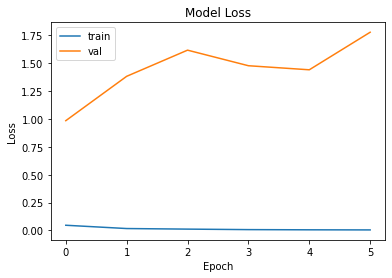

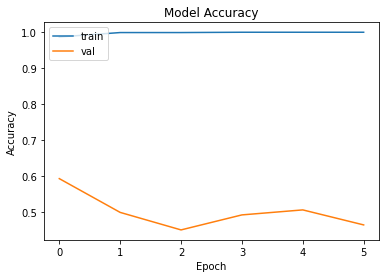

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.980


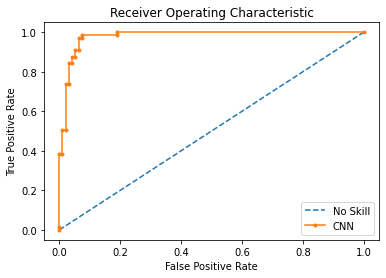

0.9795951417004048
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 320us/step - loss: 0.0243 - acc: 0.9957 - precision_m: 0.9947 - recall_m: 0.9984 - f1_m: 0.9965 - val_loss: 1.1502 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 334us/step - loss: 0.0140 - acc: 0.9991 - precision_m: 0.9986 - recall_m: 1.0000 - f1_m: 0.9993 - val_loss: 1.5497 - val_acc: 0.4549 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 309us/step - loss: 0.0085 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.6287 - val_acc: 0.4514 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0085 - acc: 0.9991 - precision_m: 0.99

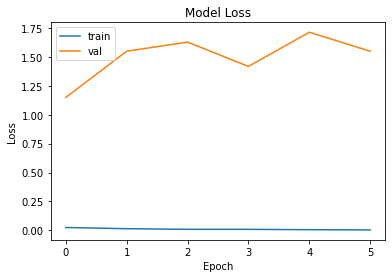

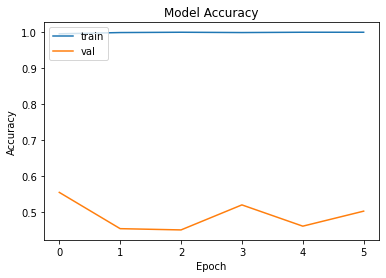

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.989


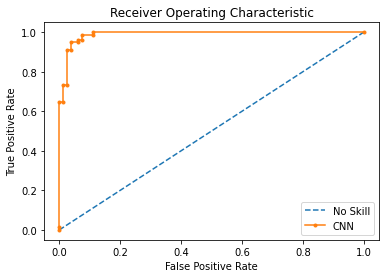

0.9890607907485545
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 328us/step - loss: 0.0159 - acc: 0.9991 - precision_m: 0.9985 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.2976 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.0093 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5386 - val_acc: 0.4757 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 308us/step - loss: 0.0063 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7977 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.0052 - acc: 1.0000 - precision_m: 1.00

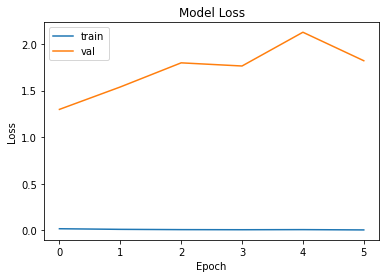

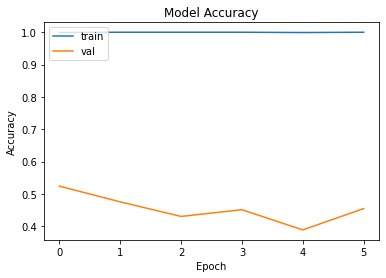

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.986


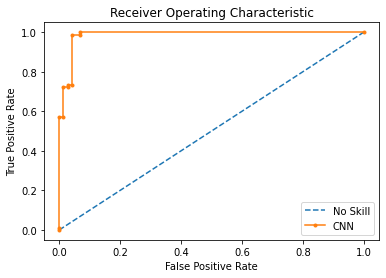

0.9864864864864865
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 314us/step - loss: 0.0091 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.4949 - val_acc: 0.4896 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 309us/step - loss: 0.0055 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1379 - val_acc: 0.3785 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0069 - acc: 0.9983 - precision_m: 0.9971 - recall_m: 1.0000 - f1_m: 0.9985 - val_loss: 1.5019 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0065 - acc: 0.9991 - precision_m: 1.00

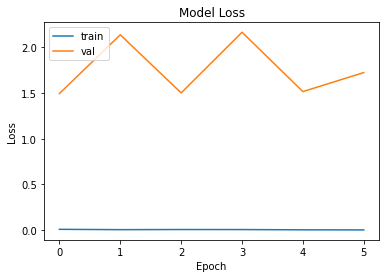

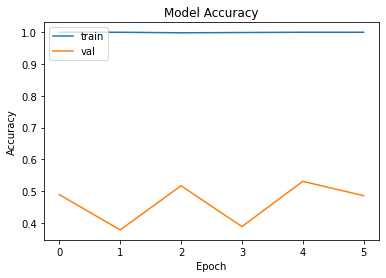

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.998


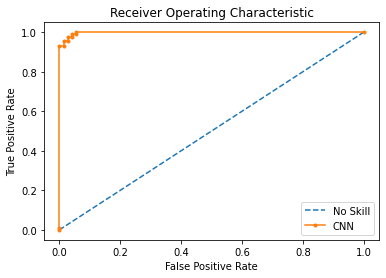

0.9979482323232323
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 316us/step - loss: 0.0083 - acc: 0.9991 - precision_m: 0.9987 - recall_m: 1.0000 - f1_m: 0.9993 - val_loss: 1.3830 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 311us/step - loss: 0.0058 - acc: 0.9991 - precision_m: 0.9984 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.4718 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 306us/step - loss: 0.0049 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9453 - val_acc: 0.4167 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.0045 - acc: 1.0000 - precision_m: 1.00

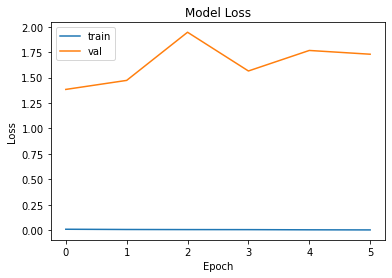

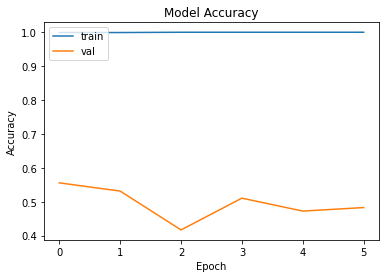

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.996


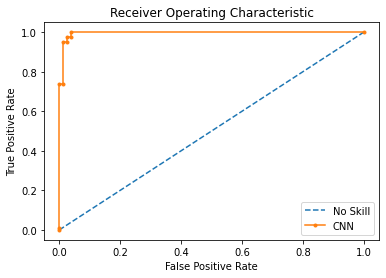

0.9956140350877193
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0064 - acc: 0.9991 - precision_m: 0.9988 - recall_m: 1.0000 - f1_m: 0.9994 - val_loss: 1.8707 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 314us/step - loss: 0.0039 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.4240 - val_acc: 0.5590 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 328us/step - loss: 0.0024 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9659 - val_acc: 0.4444 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0020 - acc: 1.0000 - precision_m: 1.00

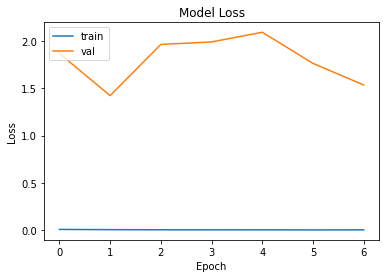

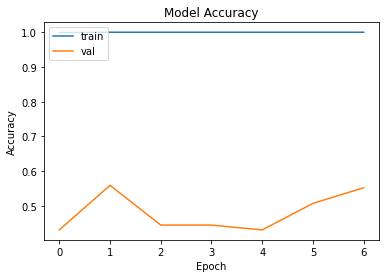

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.990


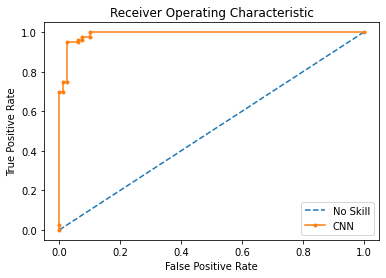

0.9901562500000001
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 318us/step - loss: 0.0035 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8868 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 319us/step - loss: 0.0023 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7091 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 308us/step - loss: 0.0016 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8099 - val_acc: 0.5139 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 322us/step - loss: 0.0017 - acc: 1.0000 - precision_m: 1.00

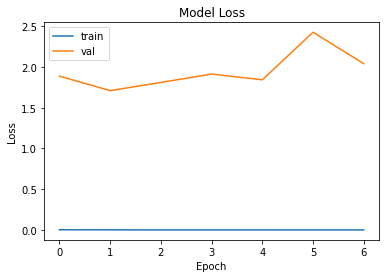

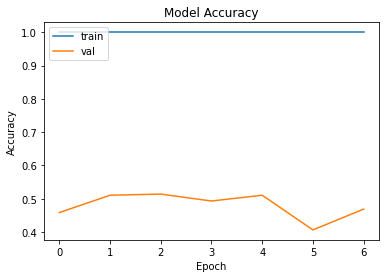

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.994


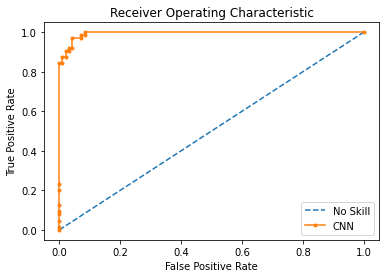

0.994140625
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0018 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7837 - val_acc: 0.5000 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 316us/step - loss: 0.0019 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9391 - val_acc: 0.4688 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 310us/step - loss: 0.0012 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9909 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 323us/step - loss: 0.0014 - acc: 1.0000 - precision_m: 1.0000 - re

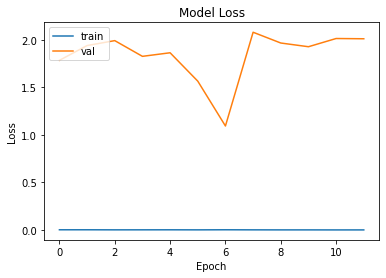

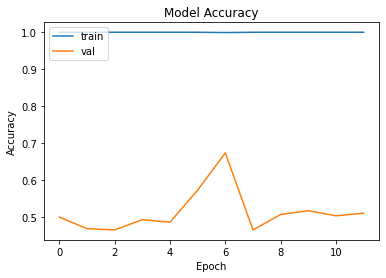

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.986


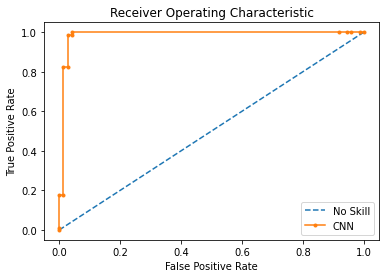

0.9863293526084224
[0.2918435455221334, 0.89875, 0.7454450058937072, 0.7708965992927551, 0.7524566078186036]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix_glove]))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',precision_m, recall_m,f1_m])

k_fold_model(model)

#### **CNN with WE (fastText)**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 782, 128)          115328    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,343,829
Trainable params: 2,343,829
Non-trainable params: 0
____________________________________________

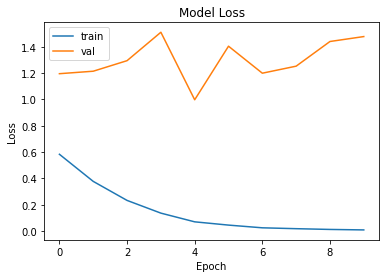

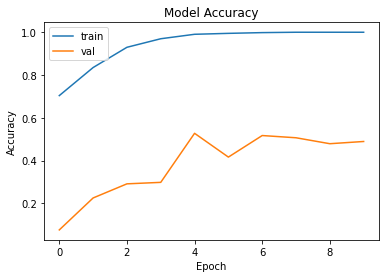

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.914


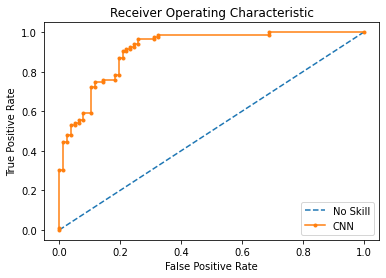

0.9137850101705524
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 317us/step - loss: 0.0778 - acc: 0.9826 - precision_m: 0.9818 - recall_m: 0.9899 - f1_m: 0.9854 - val_loss: 1.3549 - val_acc: 0.4444 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 320us/step - loss: 0.0334 - acc: 0.9948 - precision_m: 0.9929 - recall_m: 0.9987 - f1_m: 0.9957 - val_loss: 1.1623 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0191 - acc: 0.9983 - precision_m: 0.9985 - recall_m: 0.9987 - f1_m: 0.9986 - val_loss: 1.2835 - val_acc: 0.5208 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 309us/step - loss: 0.0120 - acc: 1.0000 - precision_m: 1.00

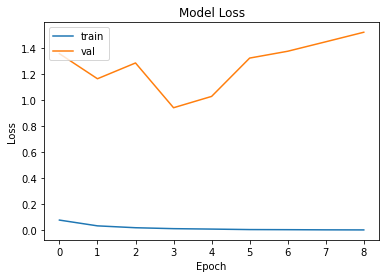

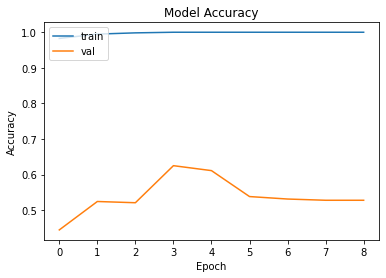

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.987


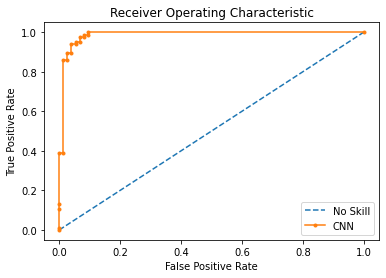

0.9866666666666666
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0136 - acc: 0.9974 - precision_m: 0.9968 - recall_m: 0.9989 - f1_m: 0.9978 - val_loss: 1.3837 - val_acc: 0.5382 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0059 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.6632 - val_acc: 0.4965 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0059 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.4652 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 309us/step - loss: 0.0035 - acc: 1.0000 - precision_m: 1.00

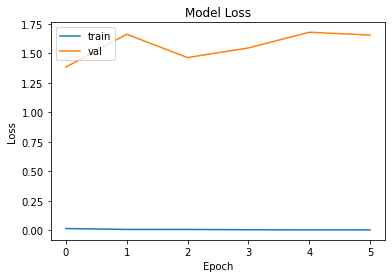

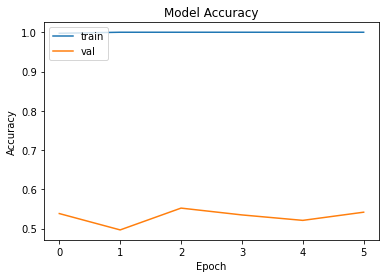

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.994


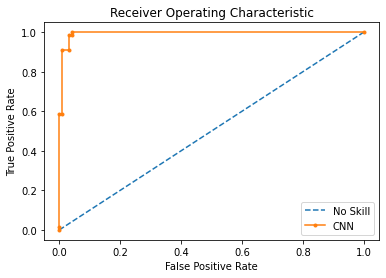

0.9935222672064777
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 316us/step - loss: 0.0068 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.3631 - val_acc: 0.5417 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 311us/step - loss: 0.0041 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.3713 - val_acc: 0.5486 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 328us/step - loss: 0.0027 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5939 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 317us/step - loss: 0.0026 - acc: 1.0000 - precision_m: 1.00

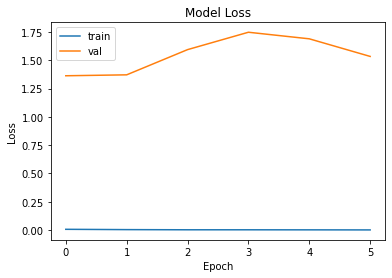

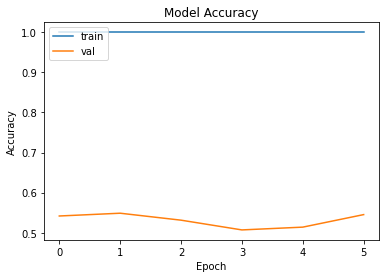

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.983


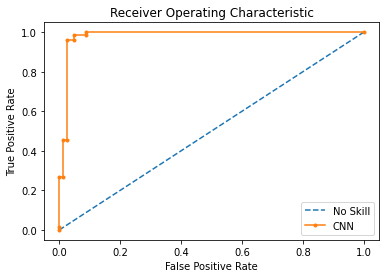

0.9828098140334428
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 326us/step - loss: 0.0064 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7697 - val_acc: 0.4826 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 308us/step - loss: 0.0042 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5951 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 312us/step - loss: 0.0030 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.2480 - val_acc: 0.5972 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 326us/step - loss: 0.0021 - acc: 1.0000 - precision_m: 1.00

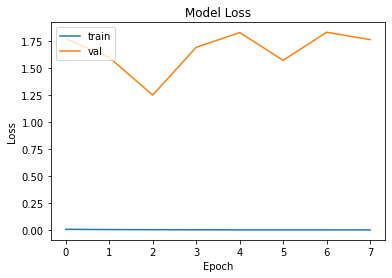

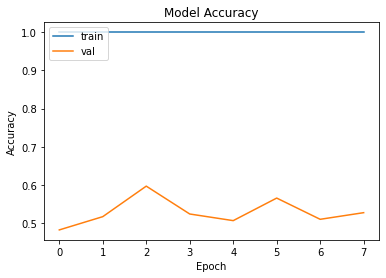

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.990


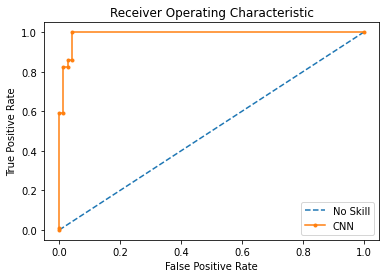

0.9902576995600251
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 316us/step - loss: 0.0020 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7446 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 310us/step - loss: 0.0014 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.6691 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 310us/step - loss: 9.9750e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5652 - val_acc: 0.5451 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 313us/step - loss: 0.0011 - acc: 1.0000 - precision_m: 

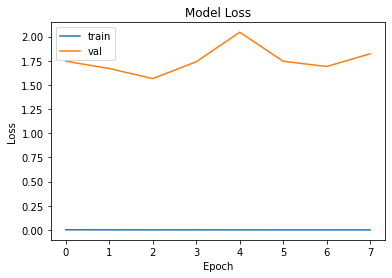

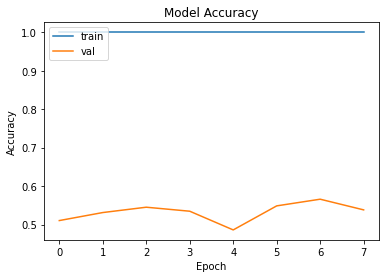

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.995


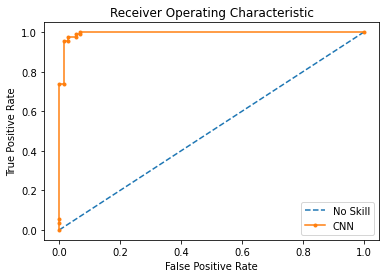

0.994949494949495
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 315us/step - loss: 0.0011 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7600 - val_acc: 0.5347 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 319us/step - loss: 9.6666e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7602 - val_acc: 0.5382 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 318us/step - loss: 6.1792e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.6316 - val_acc: 0.5660 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 318us/step - loss: 6.9606e-04 - acc: 1.0000 - precis

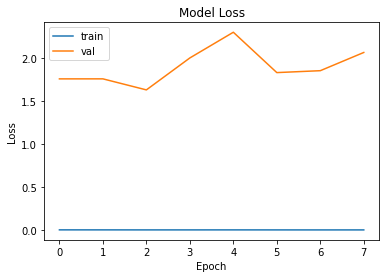

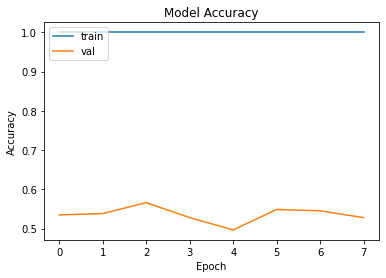

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.998


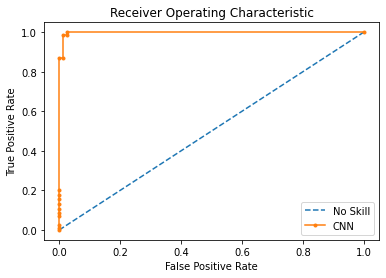

0.9981203007518797
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 321us/step - loss: 6.9920e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9208 - val_acc: 0.5347 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 313us/step - loss: 6.4563e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.7822 - val_acc: 0.5486 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 312us/step - loss: 4.5775e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8576 - val_acc: 0.5417 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 321us/step - loss: 4.2323e-04 - acc: 1.0000 - p

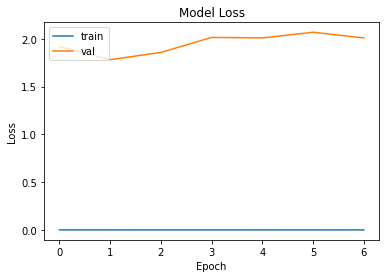

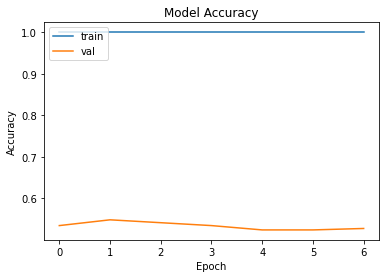

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.990


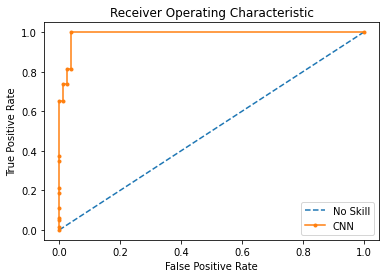

0.99
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 312us/step - loss: 4.8795e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.0617 - val_acc: 0.5486 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 313us/step - loss: 3.8159e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.6656 - val_acc: 0.5938 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 326us/step - loss: 3.8455e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.0349 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 311us/step - loss: 3.0078e-04 - acc: 1.0000 - precision_m: 1.

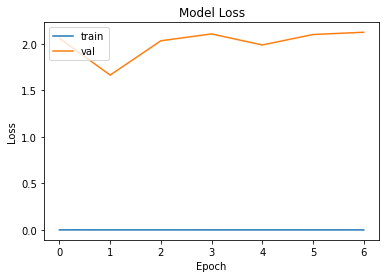

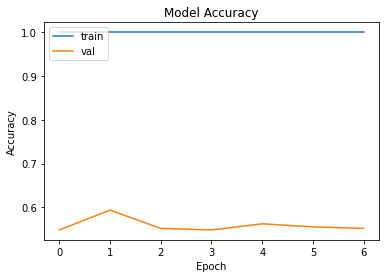

No Skill: ROC AUC=0.500
CNN: ROC AUC=1.000


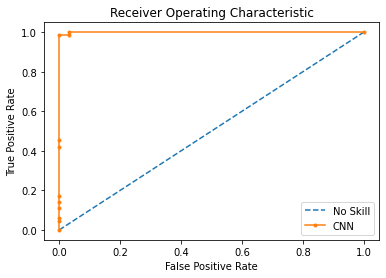

0.99951171875
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 0s 317us/step - loss: 4.6965e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9275 - val_acc: 0.5382 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 0s 322us/step - loss: 3.5686e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.1594 - val_acc: 0.5347 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 0s 321us/step - loss: 4.3139e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.2380 - val_acc: 0.5069 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 0s 317us/step - loss: 3.7644e-04 - acc: 1.0000 - precis

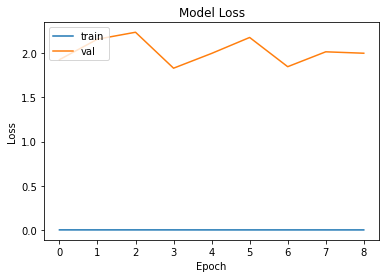

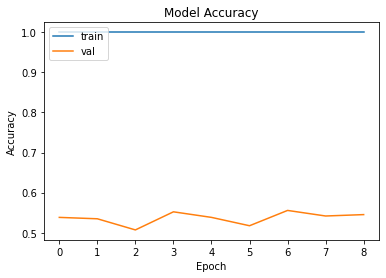

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.991


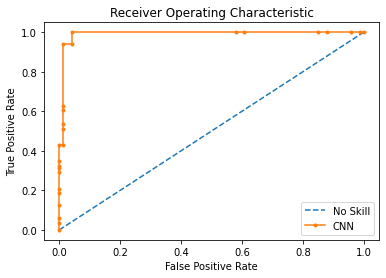

0.9907291011942174
[0.3132168733708386, 0.9049999999999999, 0.7498809498548508, 0.7760197341442108, 0.7573307001590728]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size - 1, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix_fasttext]))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

### BiDirectional Long Short Term Memory (BiLSTM)

#### **BiLSTM without WE**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
masking_1 (Masking)          (None, 784, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

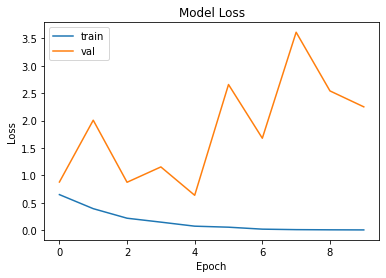

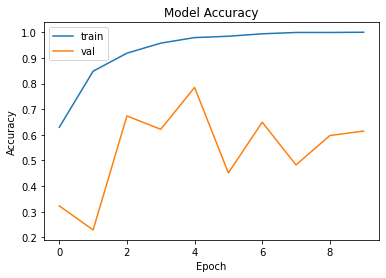

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.890


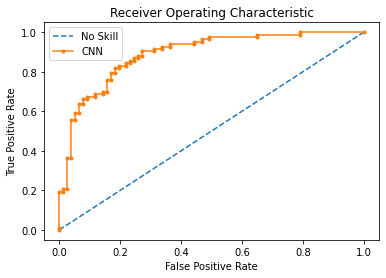

0.8903145047723361
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.1115 - acc: 0.9618 - precision_m: 0.9759 - recall_m: 0.9624 - f1_m: 0.9682 - val_loss: 1.1368 - val_acc: 0.7083 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 145s 125ms/step - loss: 0.0251 - acc: 0.9948 - precision_m: 0.9974 - recall_m: 0.9946 - f1_m: 0.9959 - val_loss: 2.2077 - val_acc: 0.5938 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0074 - acc: 0.9974 - precision_m: 0.9972 - recall_m: 0.9986 - f1_m: 0.9979 - val_loss: 2.5436 - val_acc: 0.5903 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 146s 127ms/step - loss: 0.0091 - acc: 0.9983 - precision

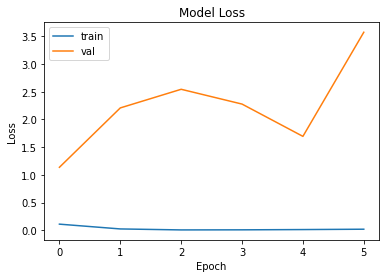

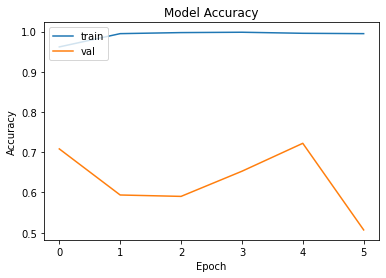

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.980


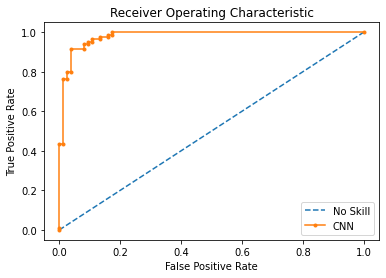

0.9802352941176471
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0648 - acc: 0.9818 - precision_m: 0.9880 - recall_m: 0.9844 - f1_m: 0.9859 - val_loss: 1.7485 - val_acc: 0.6007 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0217 - acc: 0.9922 - precision_m: 0.9958 - recall_m: 0.9922 - f1_m: 0.9938 - val_loss: 2.7413 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0183 - acc: 0.9939 - precision_m: 0.9932 - recall_m: 0.9975 - f1_m: 0.9952 - val_loss: 1.3005 - val_acc: 0.7639 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0135 - acc: 0.9965 - precision

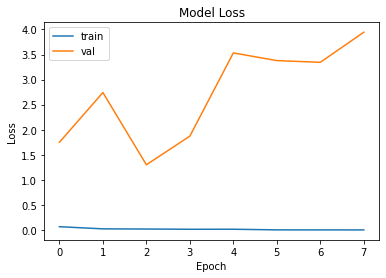

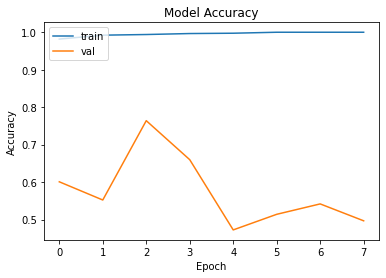

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.962


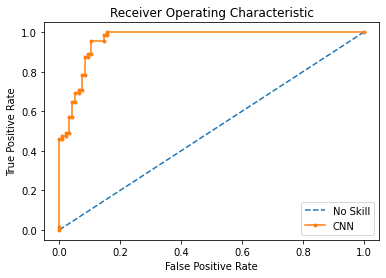

0.9621052631578947
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0293 - acc: 0.9913 - precision_m: 0.9965 - recall_m: 0.9909 - f1_m: 0.9935 - val_loss: 1.4178 - val_acc: 0.7361 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0280 - acc: 0.9922 - precision_m: 0.9959 - recall_m: 0.9921 - f1_m: 0.9937 - val_loss: 2.2090 - val_acc: 0.6597 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0502 - acc: 0.9826 - precision_m: 0.9852 - recall_m: 0.9875 - f1_m: 0.9858 - val_loss: 1.2762 - val_acc: 0.7604 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0319 - acc: 0.9878 - precision

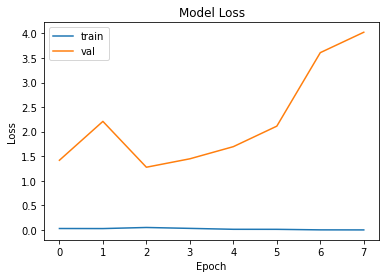

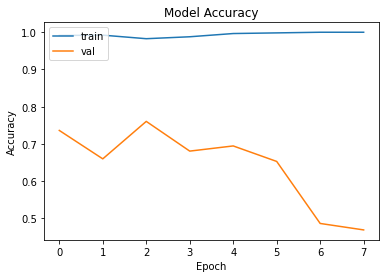

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.955


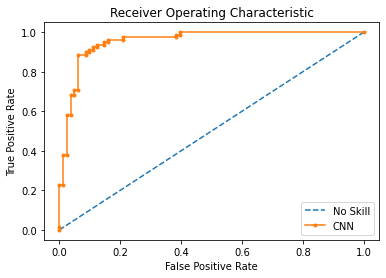

0.9554617909048289
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0562 - acc: 0.9783 - precision_m: 0.9810 - recall_m: 0.9841 - f1_m: 0.9816 - val_loss: 3.2832 - val_acc: 0.4167 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0256 - acc: 0.9905 - precision_m: 0.9905 - recall_m: 0.9947 - f1_m: 0.9924 - val_loss: 0.9374 - val_acc: 0.7743 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0320 - acc: 0.9878 - precision_m: 0.9927 - recall_m: 0.9868 - f1_m: 0.9892 - val_loss: 4.5158 - val_acc: 0.2812 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0176 - acc: 0.9957 - precision

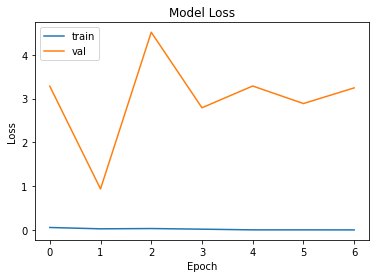

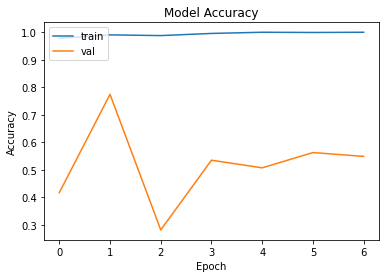

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.971


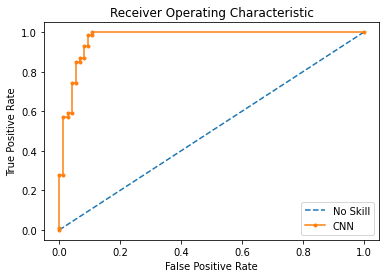

0.9706159648020113
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.1308 - acc: 0.9549 - precision_m: 0.9726 - recall_m: 0.9571 - f1_m: 0.9622 - val_loss: 1.8880 - val_acc: 0.4618 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 143s 124ms/step - loss: 0.0319 - acc: 0.9922 - precision_m: 0.9920 - recall_m: 0.9956 - f1_m: 0.9936 - val_loss: 2.1951 - val_acc: 0.5938 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0137 - acc: 0.9957 - precision_m: 0.9974 - recall_m: 0.9960 - f1_m: 0.9966 - val_loss: 2.8613 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 145s 125ms/step - loss: 0.0085 - acc: 0.9965 - precision

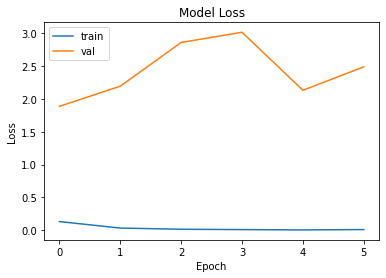

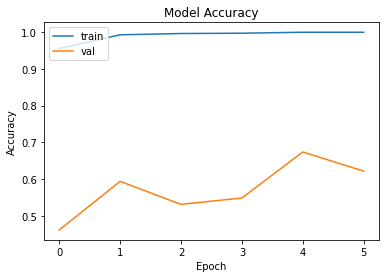

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.976


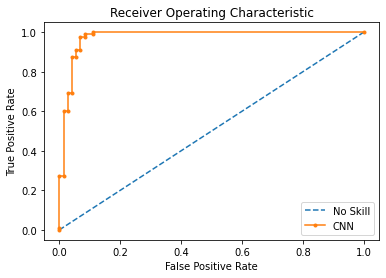

0.9764835858585859
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0345 - acc: 0.9913 - precision_m: 0.9907 - recall_m: 0.9956 - f1_m: 0.9928 - val_loss: 2.8324 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0093 - acc: 0.9983 - precision_m: 0.9985 - recall_m: 0.9985 - f1_m: 0.9985 - val_loss: 3.5608 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0060 - acc: 0.9983 - precision_m: 0.9986 - recall_m: 0.9989 - f1_m: 0.9987 - val_loss: 1.8794 - val_acc: 0.6736 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0222 - acc: 0.9931 - precision

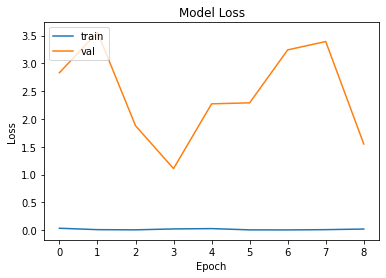

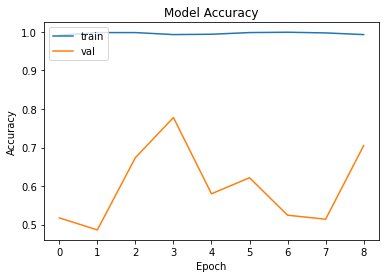

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.976


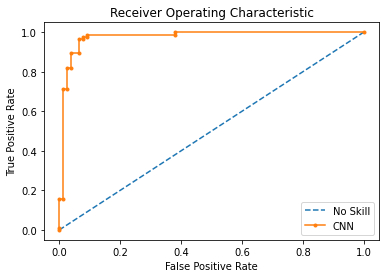

0.9757205513784462
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0393 - acc: 0.9887 - precision_m: 0.9957 - recall_m: 0.9862 - f1_m: 0.9906 - val_loss: 2.0506 - val_acc: 0.5451 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 144s 125ms/step - loss: 0.0127 - acc: 0.9965 - precision_m: 0.9959 - recall_m: 0.9984 - f1_m: 0.9971 - val_loss: 1.4854 - val_acc: 0.7083 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 0.0027 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.0601 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 146s 127ms/step - loss: 8.6429e-04 - acc: 1.0000 - preci

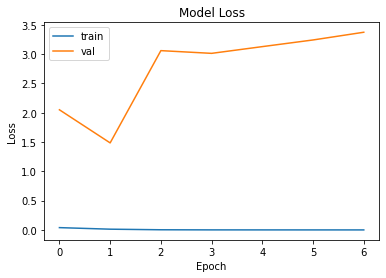

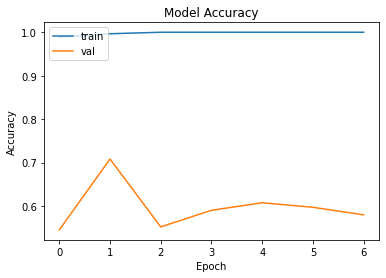

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.965


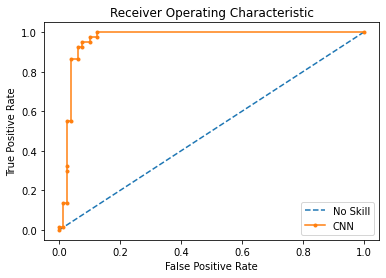

0.965
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 146s 126ms/step - loss: 0.0023 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.6134 - val_acc: 0.6250 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 146s 127ms/step - loss: 8.0088e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7305 - val_acc: 0.6389 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 145s 126ms/step - loss: 4.3154e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7893 - val_acc: 0.6528 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 145s 126ms/step - loss: 3.1722e-04 - acc: 1.0000 - precision_

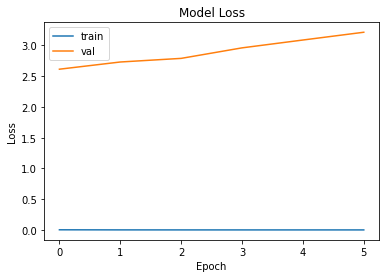

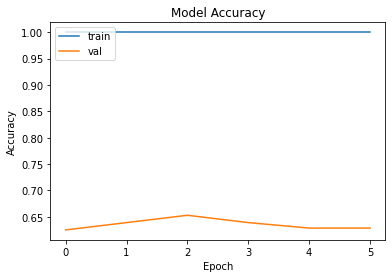

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.976


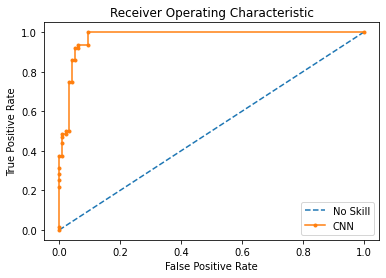

0.97607421875
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 145s 126ms/step - loss: 8.8110e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.1339 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 145s 126ms/step - loss: 4.8737e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.3048 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 147s 127ms/step - loss: 3.5561e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.4425 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 146s 127ms/step - loss: 2.6915e-04 - acc: 1.0000 

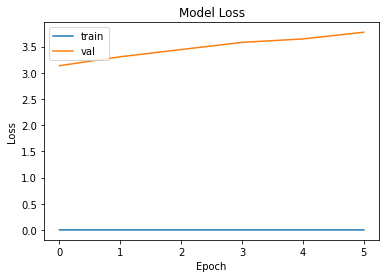

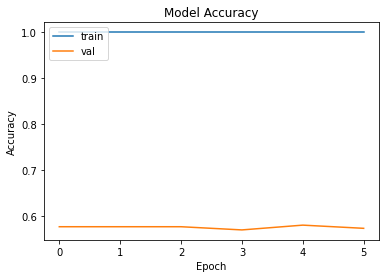

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.991


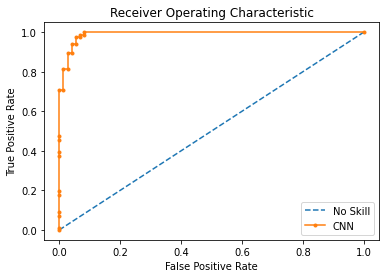

0.9908862350722816
[0.4305835845991532, 0.9043749999999999, 0.7601618808507918, 0.733133117556572, 0.7375764042139054]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **BiLSTM with WE (word2vec)**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
masking_2 (Masking)          (None, 784, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

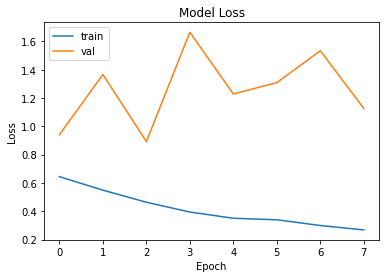

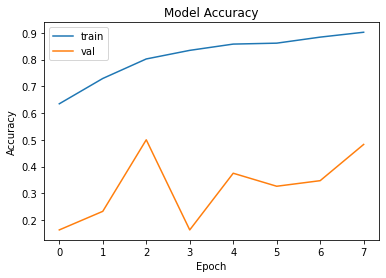

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.818


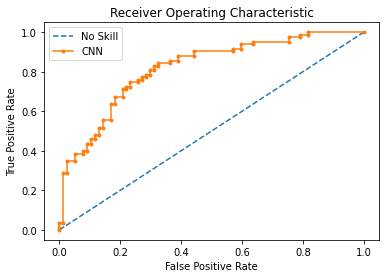

0.817868878109842
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 142s 123ms/step - loss: 0.4162 - acc: 0.8186 - precision_m: 0.8338 - recall_m: 0.8818 - f1_m: 0.8525 - val_loss: 1.0956 - val_acc: 0.4965 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.3622 - acc: 0.8602 - precision_m: 0.8743 - recall_m: 0.9075 - f1_m: 0.8873 - val_loss: 1.4116 - val_acc: 0.3333 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.3213 - acc: 0.8724 - precision_m: 0.8828 - recall_m: 0.9130 - f1_m: 0.8939 - val_loss: 1.8751 - val_acc: 0.2778 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 142s 123ms/step - loss: 0.3046 - acc: 0.8741 - precision_

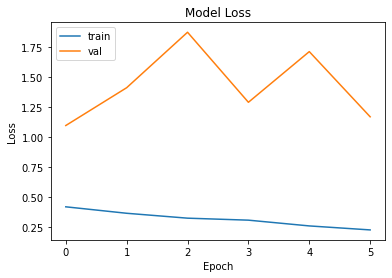

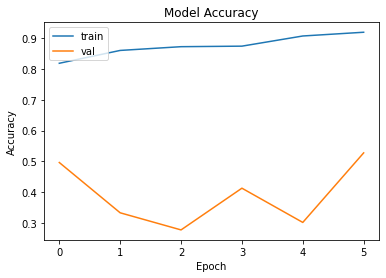

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.859


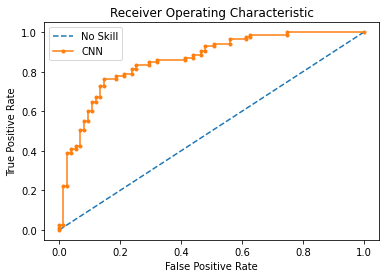

0.8585098039215686
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.3469 - acc: 0.8550 - precision_m: 0.8792 - recall_m: 0.9004 - f1_m: 0.8866 - val_loss: 1.3880 - val_acc: 0.3958 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.3127 - acc: 0.8776 - precision_m: 0.8872 - recall_m: 0.9312 - f1_m: 0.9056 - val_loss: 1.7768 - val_acc: 0.2951 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.3213 - acc: 0.8672 - precision_m: 0.8931 - recall_m: 0.9191 - f1_m: 0.8963 - val_loss: 1.5235 - val_acc: 0.2743 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.3406 - acc: 0.8559 - precision

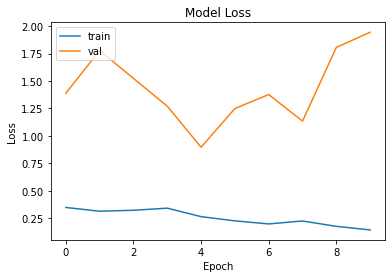

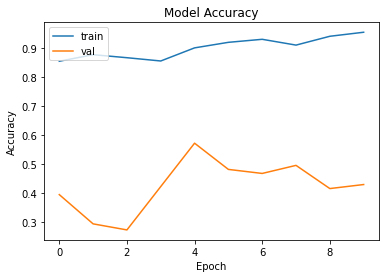

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.876


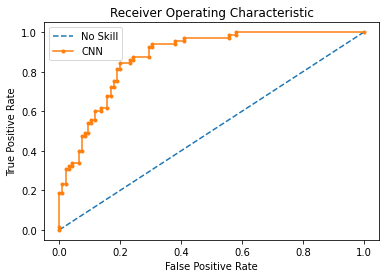

0.8764372469635627
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.2673 - acc: 0.9028 - precision_m: 0.9171 - recall_m: 0.9305 - f1_m: 0.9206 - val_loss: 1.7249 - val_acc: 0.3368 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.2206 - acc: 0.9167 - precision_m: 0.9185 - recall_m: 0.9522 - f1_m: 0.9321 - val_loss: 1.6972 - val_acc: 0.3958 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.1872 - acc: 0.9271 - precision_m: 0.9358 - recall_m: 0.9519 - f1_m: 0.9413 - val_loss: 1.2243 - val_acc: 0.4896 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.1878 - acc: 0.9280 - precision

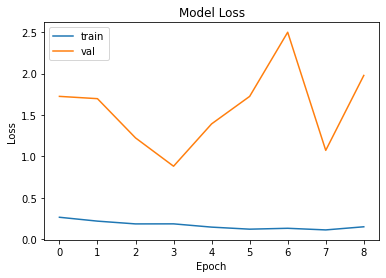

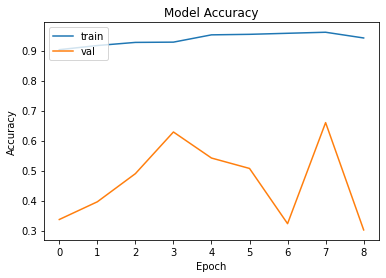

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.900


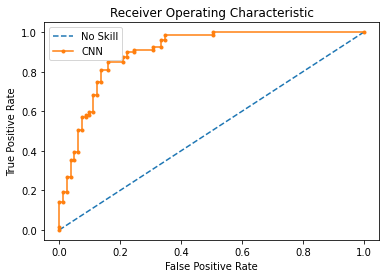

0.90014064697609
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.2034 - acc: 0.9297 - precision_m: 0.9306 - recall_m: 0.9573 - f1_m: 0.9422 - val_loss: 1.3346 - val_acc: 0.4931 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 142s 123ms/step - loss: 0.1561 - acc: 0.9410 - precision_m: 0.9387 - recall_m: 0.9659 - f1_m: 0.9508 - val_loss: 2.0359 - val_acc: 0.3889 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.1329 - acc: 0.9549 - precision_m: 0.9505 - recall_m: 0.9788 - f1_m: 0.9632 - val_loss: 1.0417 - val_acc: 0.6528 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.1615 - acc: 0.9323 - precision_m

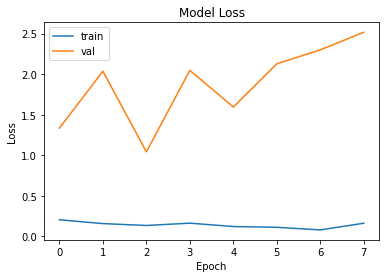

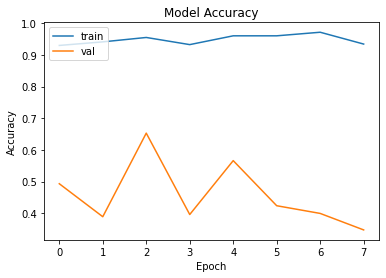

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.955


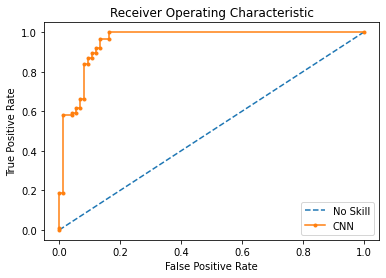

0.9550597108736644
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 142s 123ms/step - loss: 0.1935 - acc: 0.9280 - precision_m: 0.9380 - recall_m: 0.9511 - f1_m: 0.9404 - val_loss: 0.7821 - val_acc: 0.6806 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.1409 - acc: 0.9444 - precision_m: 0.9405 - recall_m: 0.9727 - f1_m: 0.9549 - val_loss: 1.5893 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 141s 123ms/step - loss: 0.0794 - acc: 0.9766 - precision_m: 0.9699 - recall_m: 0.9910 - f1_m: 0.9798 - val_loss: 1.5617 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.1609 - acc: 0.9288 - precision

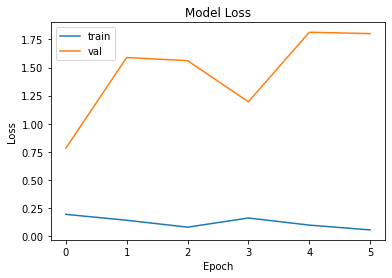

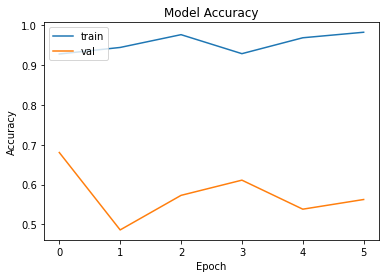

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.958


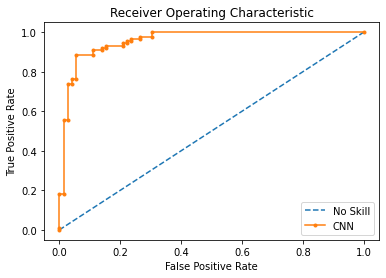

0.9584911616161617
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.1419 - acc: 0.9540 - precision_m: 0.9540 - recall_m: 0.9736 - f1_m: 0.9624 - val_loss: 1.3677 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.0818 - acc: 0.9722 - precision_m: 0.9694 - recall_m: 0.9849 - f1_m: 0.9764 - val_loss: 1.2927 - val_acc: 0.6146 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.0882 - acc: 0.9705 - precision_m: 0.9679 - recall_m: 0.9847 - f1_m: 0.9753 - val_loss: 2.1165 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 141s 122ms/step - loss: 0.0652 - acc: 0.9783 - precision

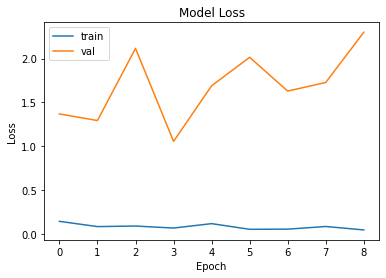

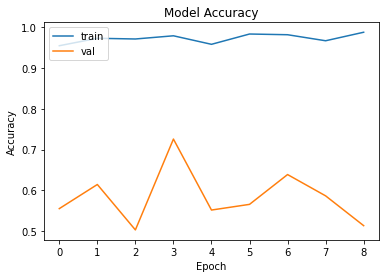

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.964


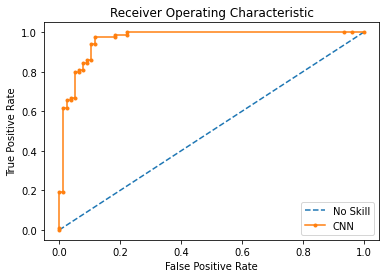

0.9635025062656641
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 142s 123ms/step - loss: 0.1070 - acc: 0.9679 - precision_m: 0.9714 - recall_m: 0.9801 - f1_m: 0.9746 - val_loss: 2.5854 - val_acc: 0.4201 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.0649 - acc: 0.9722 - precision_m: 0.9734 - recall_m: 0.9830 - f1_m: 0.9776 - val_loss: 2.6534 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.0806 - acc: 0.9705 - precision_m: 0.9728 - recall_m: 0.9806 - f1_m: 0.9756 - val_loss: 2.6137 - val_acc: 0.4097 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.0706 - acc: 0.9731 - precision

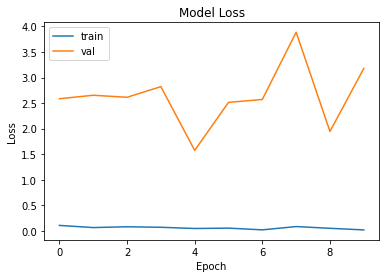

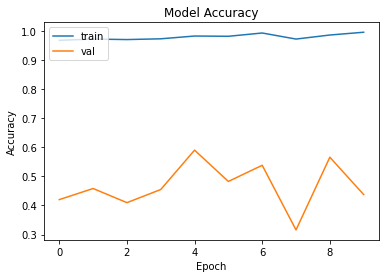

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.952


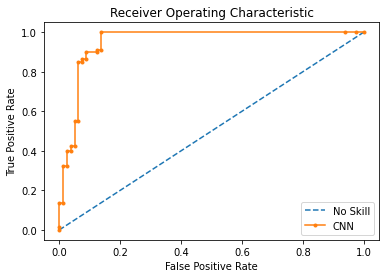

0.9520312500000001
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.0295 - acc: 0.9922 - precision_m: 0.9928 - recall_m: 0.9949 - f1_m: 0.9936 - val_loss: 4.7747 - val_acc: 0.3264 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.0709 - acc: 0.9740 - precision_m: 0.9760 - recall_m: 0.9836 - f1_m: 0.9790 - val_loss: 1.8469 - val_acc: 0.6285 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.0199 - acc: 0.9965 - precision_m: 0.9961 - recall_m: 0.9986 - f1_m: 0.9973 - val_loss: 3.3436 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.0186 - acc: 0.9948 - precision

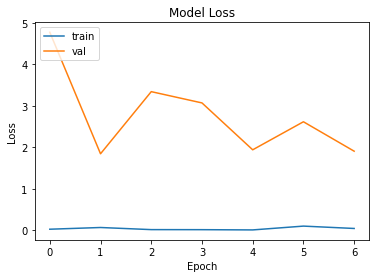

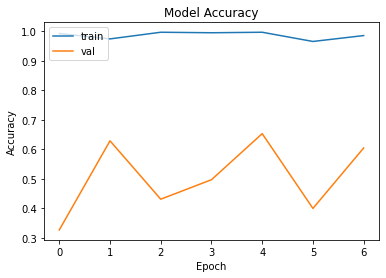

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.946


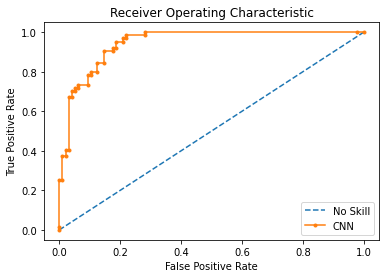

0.9459635416666666
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.0527 - acc: 0.9835 - precision_m: 0.9820 - recall_m: 0.9909 - f1_m: 0.9860 - val_loss: 2.7699 - val_acc: 0.4201 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 140s 121ms/step - loss: 0.0466 - acc: 0.9826 - precision_m: 0.9869 - recall_m: 0.9852 - f1_m: 0.9856 - val_loss: 3.7793 - val_acc: 0.3715 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 140s 122ms/step - loss: 0.0456 - acc: 0.9861 - precision_m: 0.9859 - recall_m: 0.9923 - f1_m: 0.9887 - val_loss: 2.7904 - val_acc: 0.4757 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 139s 121ms/step - loss: 0.0169 - acc: 0.9983 - precision

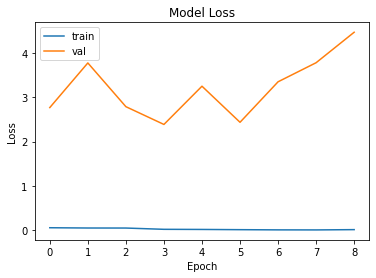

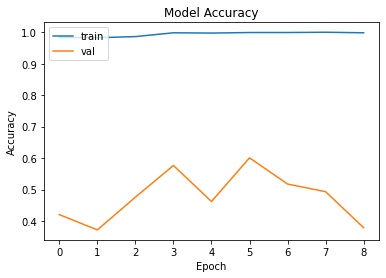

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.943


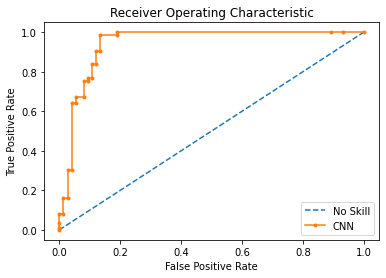

0.9426461345065995
[0.409178140219301, 0.8537500000000001, 0.7035386213660241, 0.7144348895549775, 0.6970216393470764]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size-1, embedding_dim, input_length=maxlen, trainable=False, weights=[embedding_matrix_word]))
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **BiLSTM with WE (GloVe)**










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
masking_1 (Masking)          (None, 784, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________

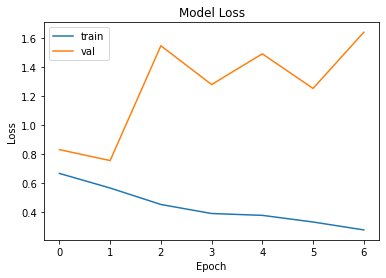

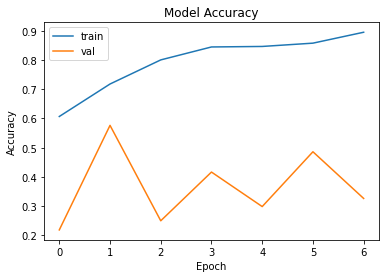

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.801


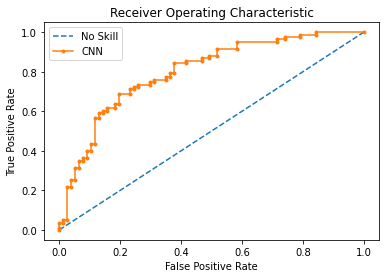

0.8006571741511501
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.4468 - acc: 0.7995 - precision_m: 0.8172 - recall_m: 0.8701 - f1_m: 0.8383 - val_loss: 0.8368 - val_acc: 0.6215 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.3928 - acc: 0.8351 - precision_m: 0.8625 - recall_m: 0.8873 - f1_m: 0.8674 - val_loss: 0.8108 - val_acc: 0.6146 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.3694 - acc: 0.8455 - precision_m: 0.8654 - recall_m: 0.9026 - f1_m: 0.8766 - val_loss: 0.7071 - val_acc: 0.6701 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.3012 - acc: 0.8819 - precision_m: 0.89

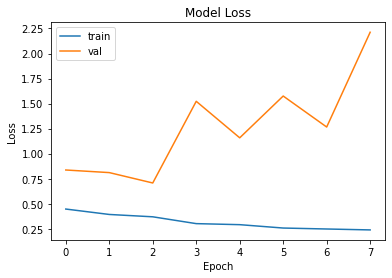

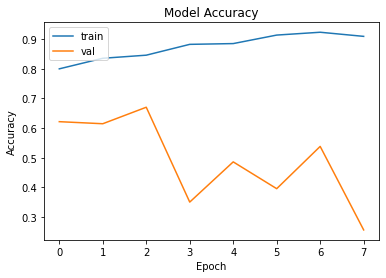

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.867


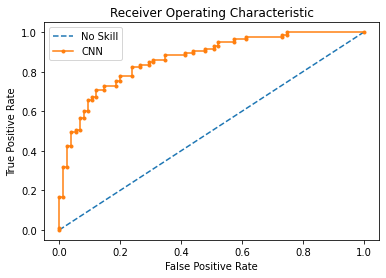

0.8665098039215686
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.3511 - acc: 0.8602 - precision_m: 0.8835 - recall_m: 0.9098 - f1_m: 0.8902 - val_loss: 1.6904 - val_acc: 0.3125 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.2927 - acc: 0.8837 - precision_m: 0.9027 - recall_m: 0.9197 - f1_m: 0.9090 - val_loss: 1.0279 - val_acc: 0.5833 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.2463 - acc: 0.9045 - precision_m: 0.9191 - recall_m: 0.9328 - f1_m: 0.9231 - val_loss: 1.3130 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.2719 - acc: 0.8906 - precision_m: 0.90

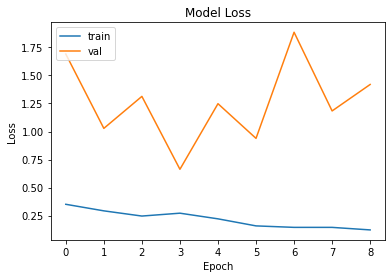

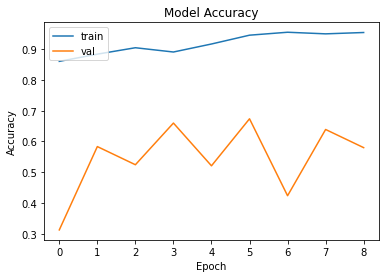

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.888


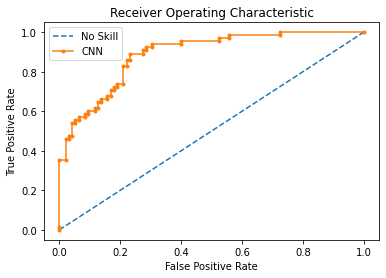

0.888421052631579
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.2709 - acc: 0.8828 - precision_m: 0.9069 - recall_m: 0.9120 - f1_m: 0.9045 - val_loss: 2.1249 - val_acc: 0.2743 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.2168 - acc: 0.9245 - precision_m: 0.9385 - recall_m: 0.9406 - f1_m: 0.9372 - val_loss: 2.5820 - val_acc: 0.2604 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.1780 - acc: 0.9410 - precision_m: 0.9444 - recall_m: 0.9642 - f1_m: 0.9525 - val_loss: 1.5543 - val_acc: 0.5417 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 94s 81ms/step - loss: 0.1763 - acc: 0.9427 - precision_m: 0.947

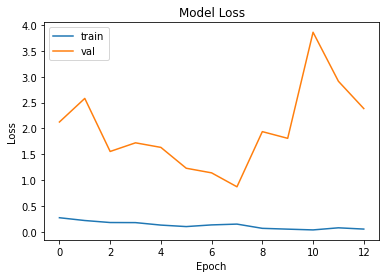

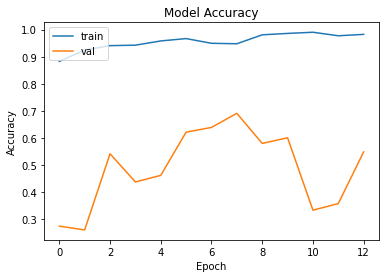

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.931


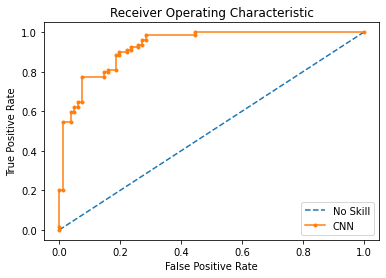

0.9306141584622598
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.1327 - acc: 0.9531 - precision_m: 0.9604 - recall_m: 0.9611 - f1_m: 0.9594 - val_loss: 1.9277 - val_acc: 0.4792 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.0960 - acc: 0.9644 - precision_m: 0.9631 - recall_m: 0.9808 - f1_m: 0.9711 - val_loss: 3.6126 - val_acc: 0.2326 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.0866 - acc: 0.9714 - precision_m: 0.9706 - recall_m: 0.9835 - f1_m: 0.9760 - val_loss: 2.0812 - val_acc: 0.5000 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.0496 - acc: 0.9878 - precision_m: 0.98

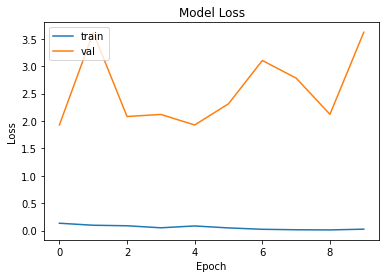

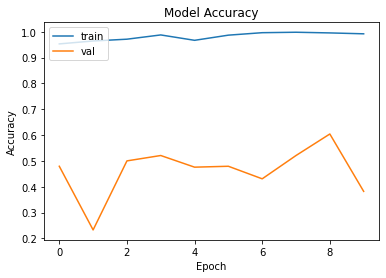

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.976


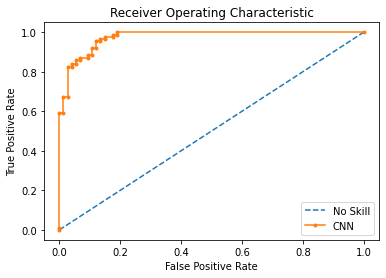

0.9756442489000627
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0597 - acc: 0.9826 - precision_m: 0.9804 - recall_m: 0.9910 - f1_m: 0.9851 - val_loss: 1.9083 - val_acc: 0.5590 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 92s 80ms/step - loss: 0.0256 - acc: 0.9905 - precision_m: 0.9889 - recall_m: 0.9959 - f1_m: 0.9922 - val_loss: 2.9317 - val_acc: 0.4201 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 92s 80ms/step - loss: 0.0145 - acc: 0.9957 - precision_m: 0.9946 - recall_m: 0.9985 - f1_m: 0.9964 - val_loss: 2.7698 - val_acc: 0.4722 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0085 - acc: 0.9991 - precision_m: 0.99

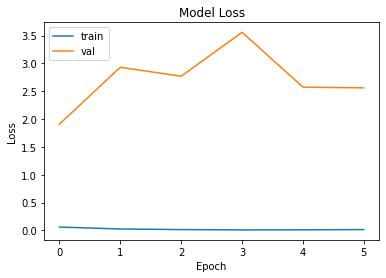

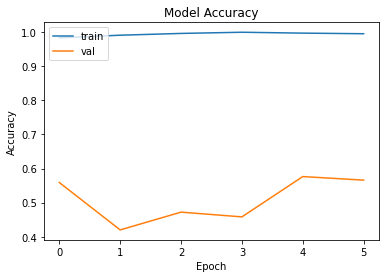

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.981


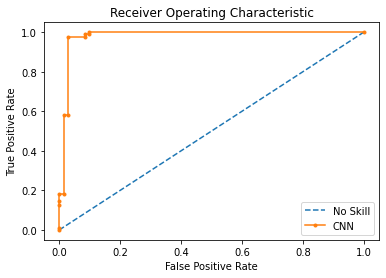

0.9813762626262627
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 94s 81ms/step - loss: 0.0868 - acc: 0.9748 - precision_m: 0.9757 - recall_m: 0.9841 - f1_m: 0.9783 - val_loss: 2.2621 - val_acc: 0.4826 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 93s 80ms/step - loss: 0.0311 - acc: 0.9922 - precision_m: 0.9929 - recall_m: 0.9946 - f1_m: 0.9936 - val_loss: 1.9130 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 92s 80ms/step - loss: 0.0293 - acc: 0.9905 - precision_m: 0.9915 - recall_m: 0.9932 - f1_m: 0.9921 - val_loss: 2.1504 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 92s 80ms/step - loss: 0.0468 - acc: 0.9887 - precision_m: 0.99

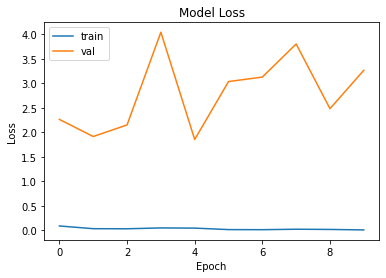

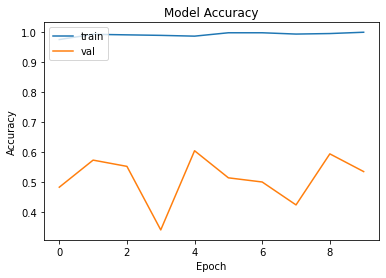

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.968


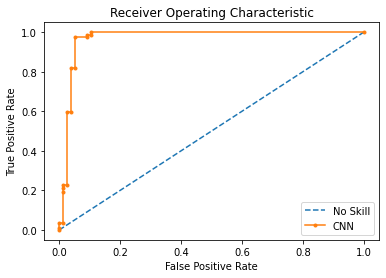

0.968358395989975
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0200 - acc: 0.9948 - precision_m: 0.9937 - recall_m: 0.9968 - f1_m: 0.9950 - val_loss: 1.7433 - val_acc: 0.6771 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 92s 80ms/step - loss: 0.0168 - acc: 0.9957 - precision_m: 0.9962 - recall_m: 0.9963 - f1_m: 0.9961 - val_loss: 1.9234 - val_acc: 0.6910 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 93s 80ms/step - loss: 0.0081 - acc: 0.9965 - precision_m: 0.9952 - recall_m: 0.9984 - f1_m: 0.9967 - val_loss: 2.9402 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0033 - acc: 1.0000 - precision_m: 1.000

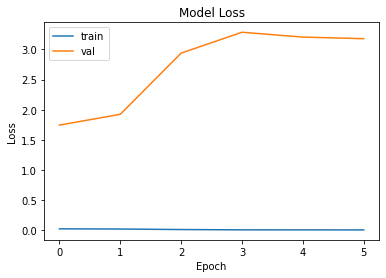

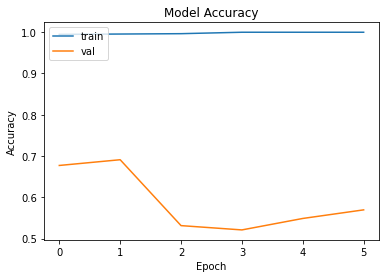

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.977


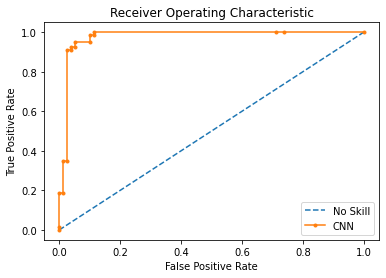

0.9770312499999999
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0094 - acc: 0.9974 - precision_m: 0.9974 - recall_m: 0.9987 - f1_m: 0.9980 - val_loss: 4.0017 - val_acc: 0.4167 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 95s 83ms/step - loss: 0.0139 - acc: 0.9948 - precision_m: 0.9960 - recall_m: 0.9958 - f1_m: 0.9958 - val_loss: 2.0787 - val_acc: 0.6319 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0065 - acc: 0.9983 - precision_m: 1.0000 - recall_m: 0.9975 - f1_m: 0.9987 - val_loss: 3.5411 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 95s 83ms/step - loss: 0.0240 - acc: 0.9922 - precision_m: 0.99

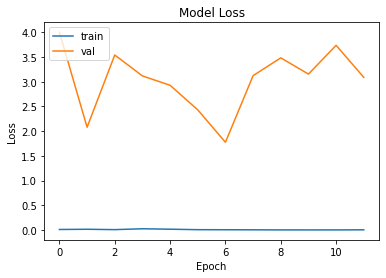

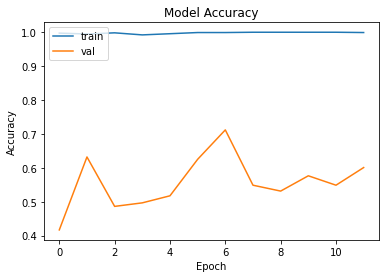

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.963


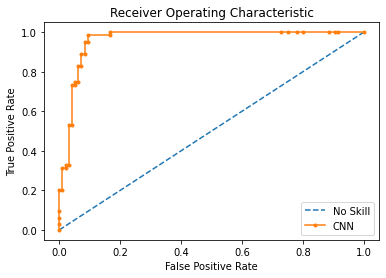

0.9627278645833334
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0273 - acc: 0.9922 - precision_m: 0.9948 - recall_m: 0.9938 - f1_m: 0.9942 - val_loss: 2.5872 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 94s 81ms/step - loss: 0.0259 - acc: 0.9896 - precision_m: 0.9873 - recall_m: 0.9955 - f1_m: 0.9911 - val_loss: 1.9844 - val_acc: 0.6389 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0165 - acc: 0.9965 - precision_m: 0.9951 - recall_m: 0.9987 - f1_m: 0.9967 - val_loss: 1.8241 - val_acc: 0.6771 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.0094 - acc: 0.9965 - precision_m: 0.99

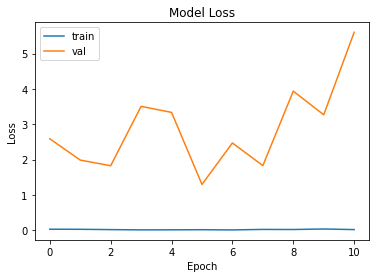

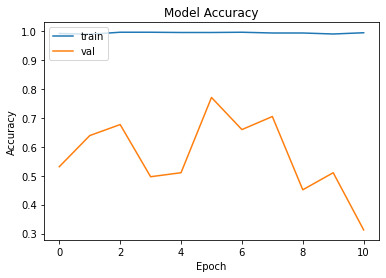

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.963


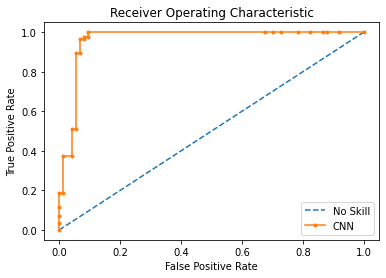

0.9632306725329981
[0.37910476216406097, 0.8712500000000001, 0.7097472348809243, 0.7165933752059936, 0.7033795315027237]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=False, weights=[embedding_matrix_glove]))
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **BiLSTM with WE (fastText)**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
masking_2 (Masking)          (None, 784, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

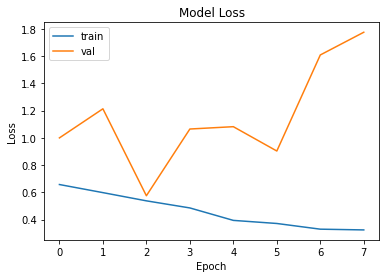

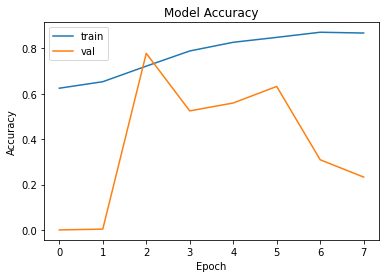

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.810


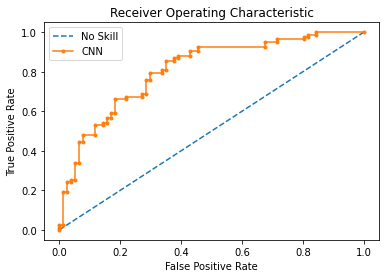

0.8100453763104365
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.4739 - acc: 0.7960 - precision_m: 0.8416 - recall_m: 0.8456 - f1_m: 0.8317 - val_loss: 1.5774 - val_acc: 0.2326 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 94s 81ms/step - loss: 0.3980 - acc: 0.8438 - precision_m: 0.8727 - recall_m: 0.8777 - f1_m: 0.8714 - val_loss: 0.6755 - val_acc: 0.6910 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.3492 - acc: 0.8550 - precision_m: 0.8842 - recall_m: 0.8913 - f1_m: 0.8832 - val_loss: 1.2108 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 94s 81ms/step - loss: 0.2992 - acc: 0.8915 - precision_m: 0.90

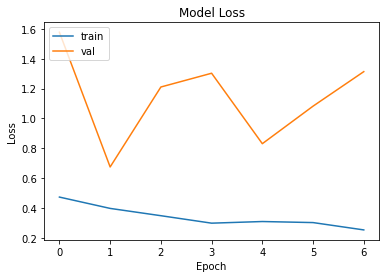

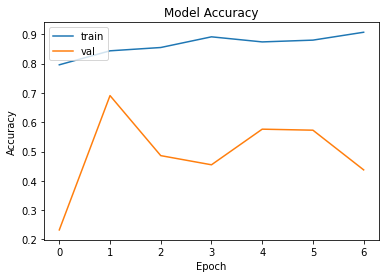

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.854


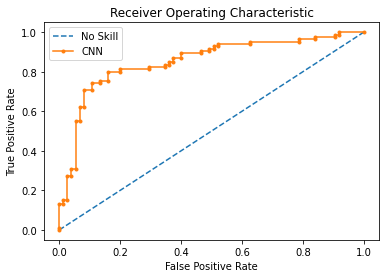

0.8541176470588235
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 95s 83ms/step - loss: 0.3711 - acc: 0.8481 - precision_m: 0.8833 - recall_m: 0.8905 - f1_m: 0.8806 - val_loss: 0.8495 - val_acc: 0.6215 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.3683 - acc: 0.8403 - precision_m: 0.8846 - recall_m: 0.8727 - f1_m: 0.8703 - val_loss: 1.7816 - val_acc: 0.2326 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.3094 - acc: 0.8802 - precision_m: 0.8927 - recall_m: 0.9249 - f1_m: 0.9045 - val_loss: 1.0803 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.2699 - acc: 0.9054 - precision_m: 0.91

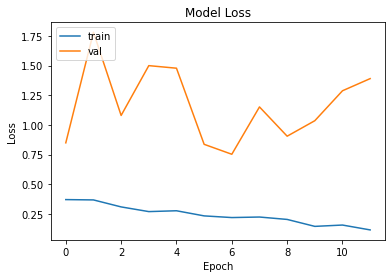

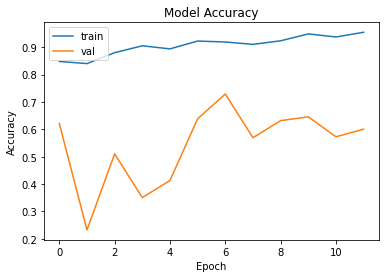

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.897


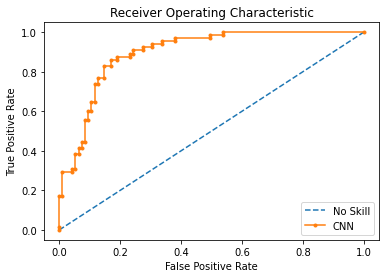

0.8966801619433198
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.2485 - acc: 0.9002 - precision_m: 0.9187 - recall_m: 0.9297 - f1_m: 0.9185 - val_loss: 0.5575 - val_acc: 0.7465 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 93s 81ms/step - loss: 0.2245 - acc: 0.9123 - precision_m: 0.9179 - recall_m: 0.9460 - f1_m: 0.9285 - val_loss: 1.0687 - val_acc: 0.5833 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.1931 - acc: 0.9332 - precision_m: 0.9505 - recall_m: 0.9440 - f1_m: 0.9437 - val_loss: 1.9008 - val_acc: 0.4757 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.2215 - acc: 0.9167 - precision_m: 0.92

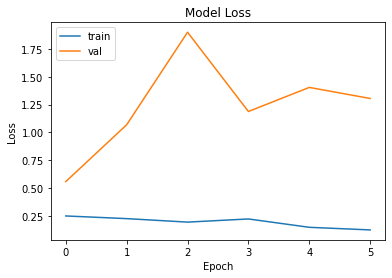

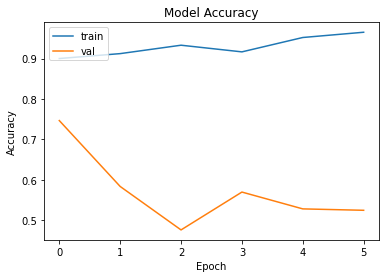

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.920


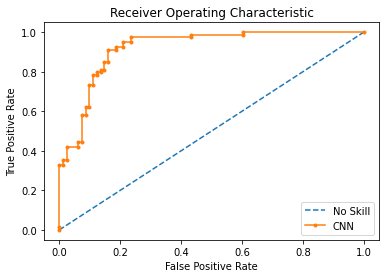

0.9203000468823254
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 99s 86ms/step - loss: 0.2402 - acc: 0.9132 - precision_m: 0.9301 - recall_m: 0.9327 - f1_m: 0.9288 - val_loss: 1.5268 - val_acc: 0.4514 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.1995 - acc: 0.9306 - precision_m: 0.9407 - recall_m: 0.9516 - f1_m: 0.9433 - val_loss: 1.4551 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.1742 - acc: 0.9332 - precision_m: 0.9340 - recall_m: 0.9611 - f1_m: 0.9455 - val_loss: 1.3028 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.1525 - acc: 0.9540 - precision_m: 0.95

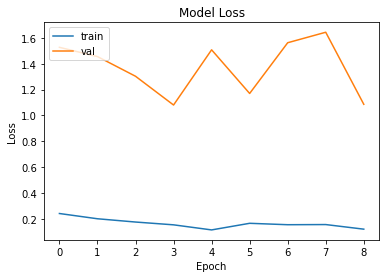

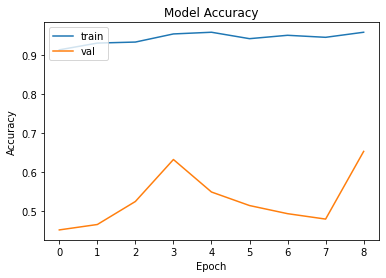

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.972


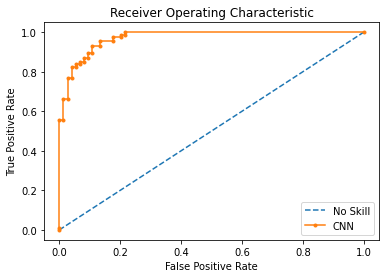

0.9720301697045883
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 99s 86ms/step - loss: 0.1374 - acc: 0.9549 - precision_m: 0.9602 - recall_m: 0.9686 - f1_m: 0.9629 - val_loss: 0.9389 - val_acc: 0.6354 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.1112 - acc: 0.9635 - precision_m: 0.9591 - recall_m: 0.9841 - f1_m: 0.9705 - val_loss: 0.6078 - val_acc: 0.7882 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.1434 - acc: 0.9410 - precision_m: 0.9539 - recall_m: 0.9533 - f1_m: 0.9497 - val_loss: 2.0429 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0803 - acc: 0.9800 - precision_m: 0.97

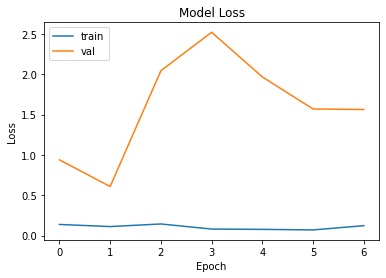

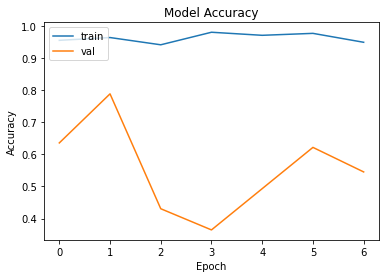

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.951


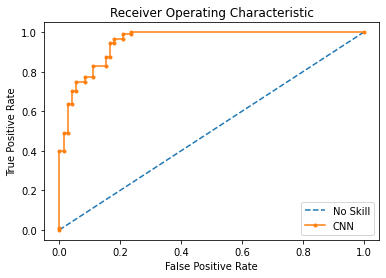

0.9512310606060606
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.1018 - acc: 0.9670 - precision_m: 0.9653 - recall_m: 0.9809 - f1_m: 0.9721 - val_loss: 1.6076 - val_acc: 0.5451 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 99s 86ms/step - loss: 0.0990 - acc: 0.9583 - precision_m: 0.9656 - recall_m: 0.9685 - f1_m: 0.9653 - val_loss: 2.0861 - val_acc: 0.4062 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 99s 86ms/step - loss: 0.0870 - acc: 0.9714 - precision_m: 0.9698 - recall_m: 0.9866 - f1_m: 0.9775 - val_loss: 1.9426 - val_acc: 0.4826 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 101s 88ms/step - loss: 0.0586 - acc: 0.9792 - precision_m: 0.9

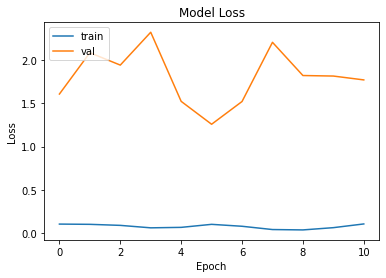

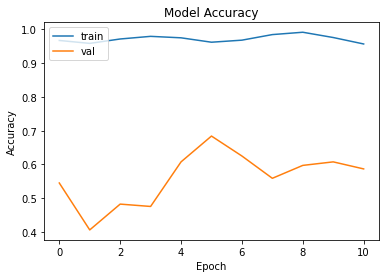

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.952


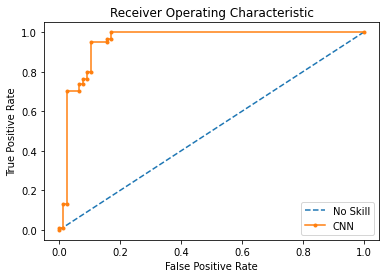

0.9515977443609023
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 94s 82ms/step - loss: 0.0718 - acc: 0.9757 - precision_m: 0.9743 - recall_m: 0.9878 - f1_m: 0.9799 - val_loss: 1.6629 - val_acc: 0.5868 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0392 - acc: 0.9852 - precision_m: 0.9834 - recall_m: 0.9927 - f1_m: 0.9876 - val_loss: 1.3418 - val_acc: 0.7083 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 95s 82ms/step - loss: 0.0369 - acc: 0.9887 - precision_m: 0.9877 - recall_m: 0.9945 - f1_m: 0.9908 - val_loss: 2.2473 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0646 - acc: 0.9722 - precision_m: 0.97

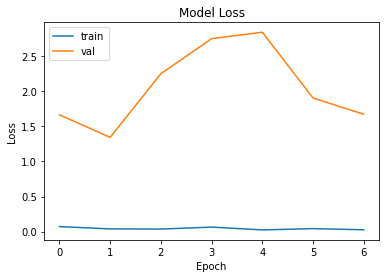

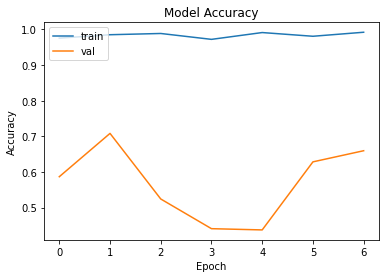

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.952


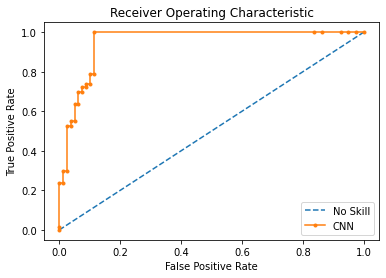

0.9524999999999999
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0635 - acc: 0.9766 - precision_m: 0.9842 - recall_m: 0.9796 - f1_m: 0.9810 - val_loss: 2.7123 - val_acc: 0.4757 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 99s 86ms/step - loss: 0.0267 - acc: 0.9922 - precision_m: 0.9926 - recall_m: 0.9944 - f1_m: 0.9933 - val_loss: 2.8931 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 98s 85ms/step - loss: 0.0300 - acc: 0.9905 - precision_m: 0.9904 - recall_m: 0.9954 - f1_m: 0.9926 - val_loss: 2.4794 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 96s 83ms/step - loss: 0.0365 - acc: 0.9913 - precision_m: 0.99

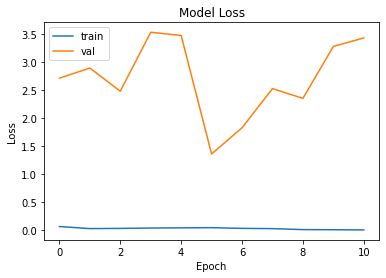

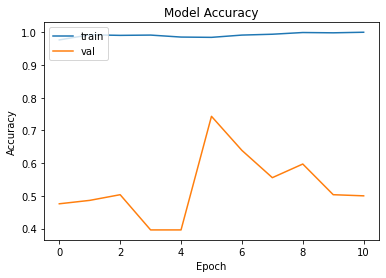

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.935


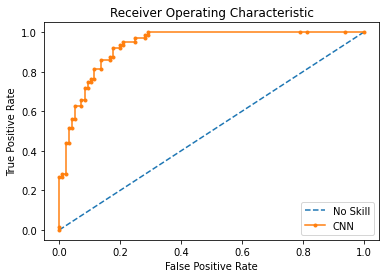

0.93505859375
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.0355 - acc: 0.9905 - precision_m: 0.9917 - recall_m: 0.9927 - f1_m: 0.9921 - val_loss: 2.4644 - val_acc: 0.5000 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.0371 - acc: 0.9913 - precision_m: 0.9917 - recall_m: 0.9943 - f1_m: 0.9928 - val_loss: 2.3826 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 97s 84ms/step - loss: 0.0326 - acc: 0.9896 - precision_m: 0.9913 - recall_m: 0.9915 - f1_m: 0.9911 - val_loss: 3.3280 - val_acc: 0.4201 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 96s 84ms/step - loss: 0.0488 - acc: 0.9800 - precision_m: 0.9798 - 

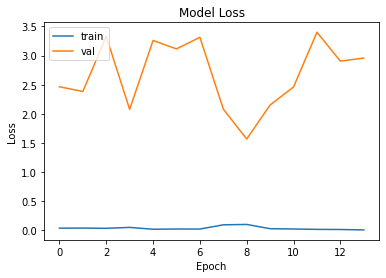

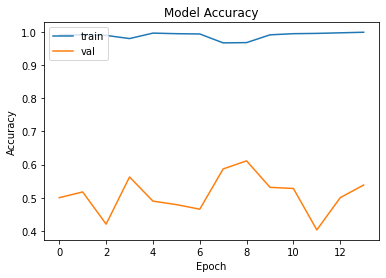

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.931


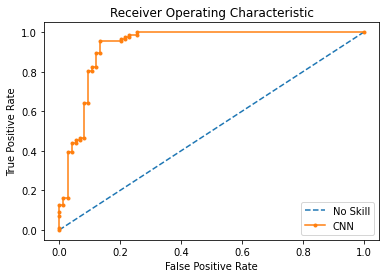

0.9310182275298553
[0.41110552008263773, 0.85125, 0.7181216096878051, 0.6579520082473754, 0.6760980051755905]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size-1, embedding_dim, input_length=maxlen, trainable=False, weights=[embedding_matrix_fasttext]))
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

### CNN-BiLSTM

#### **CNN-BiLSTM without WE**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 780, 128)          192128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 390, 128)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 390, 128)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

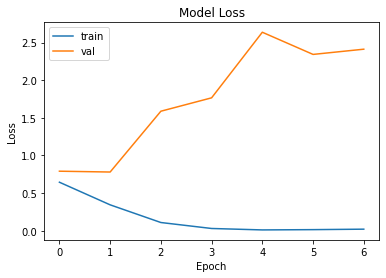

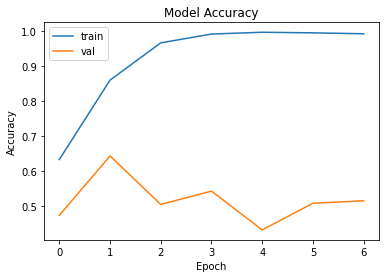

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.880


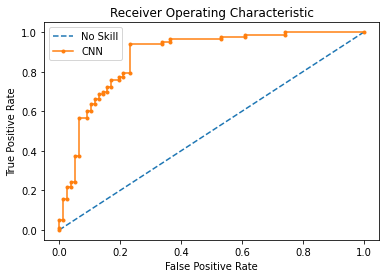

0.8798310123611328
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 37ms/step - loss: 0.1678 - acc: 0.9436 - precision_m: 0.9488 - recall_m: 0.9626 - f1_m: 0.9543 - val_loss: 1.8355 - val_acc: 0.4271 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0601 - acc: 0.9844 - precision_m: 0.9855 - recall_m: 0.9892 - f1_m: 0.9870 - val_loss: 2.3768 - val_acc: 0.3854 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0481 - acc: 0.9809 - precision_m: 0.9825 - recall_m: 0.9874 - f1_m: 0.9843 - val_loss: 3.0963 - val_acc: 0.3090 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0139 - acc: 0.9974 - precision_m: 0.99

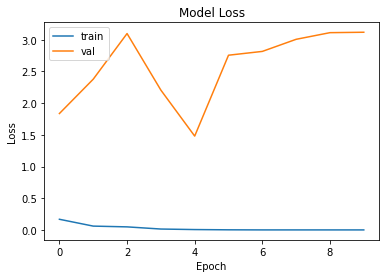

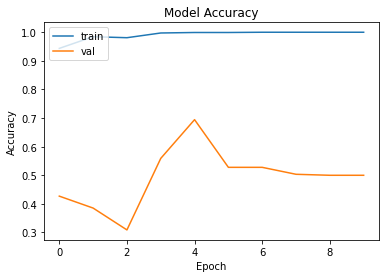

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.933


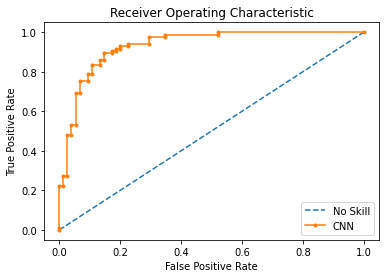

0.9327058823529412
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0281 - acc: 0.9896 - precision_m: 0.9919 - recall_m: 0.9906 - f1_m: 0.9911 - val_loss: 2.0502 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 37ms/step - loss: 0.0149 - acc: 0.9948 - precision_m: 0.9943 - recall_m: 0.9976 - f1_m: 0.9959 - val_loss: 1.9341 - val_acc: 0.6389 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0259 - acc: 0.9931 - precision_m: 0.9959 - recall_m: 0.9931 - f1_m: 0.9944 - val_loss: 1.4030 - val_acc: 0.7118 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0085 - acc: 0.9974 - precision_m: 0.99

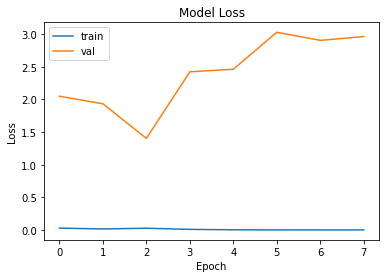

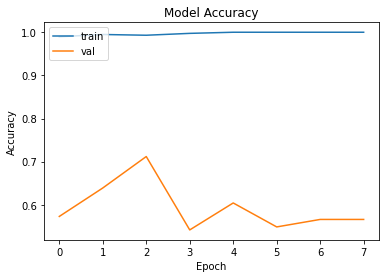

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.963


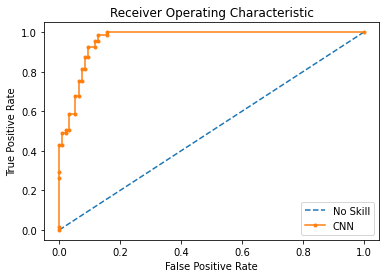

0.962914979757085
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0240 - acc: 0.9913 - precision_m: 0.9932 - recall_m: 0.9926 - f1_m: 0.9927 - val_loss: 1.6261 - val_acc: 0.6528 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0048 - acc: 0.9983 - precision_m: 0.9985 - recall_m: 0.9987 - f1_m: 0.9985 - val_loss: 3.1731 - val_acc: 0.4618 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0031 - acc: 0.9991 - precision_m: 0.9986 - recall_m: 1.0000 - f1_m: 0.9993 - val_loss: 1.9404 - val_acc: 0.6632 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0032 - acc: 0.9991 - precision_m: 1.000

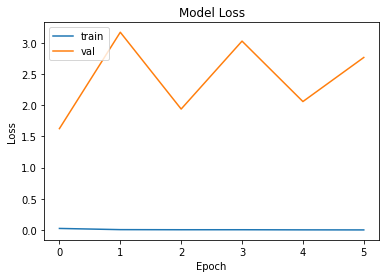

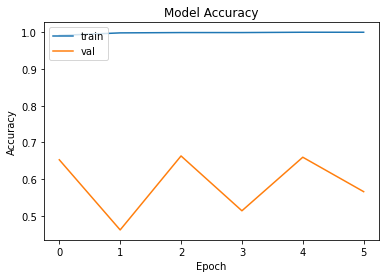

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.968


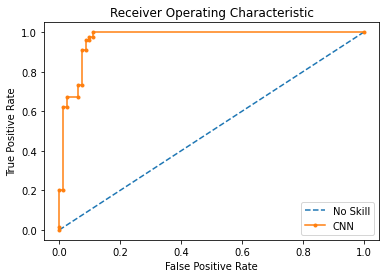

0.9681200187529301
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0260 - acc: 0.9913 - precision_m: 0.9920 - recall_m: 0.9948 - f1_m: 0.9931 - val_loss: 0.9718 - val_acc: 0.7778 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0084 - acc: 0.9957 - precision_m: 0.9985 - recall_m: 0.9952 - f1_m: 0.9968 - val_loss: 2.9389 - val_acc: 0.4965 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0070 - acc: 0.9983 - precision_m: 0.9987 - recall_m: 0.9985 - f1_m: 0.9986 - val_loss: 3.1476 - val_acc: 0.4236 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0058 - acc: 0.9983 - precision_m: 0.99

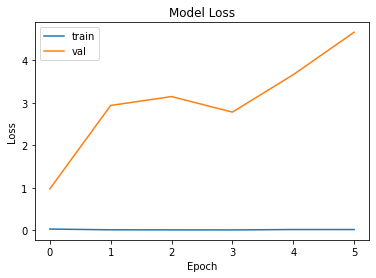

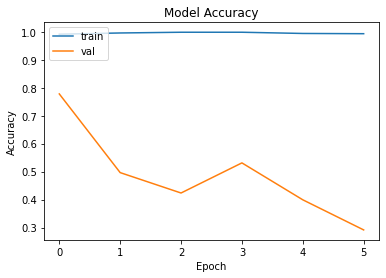

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.987


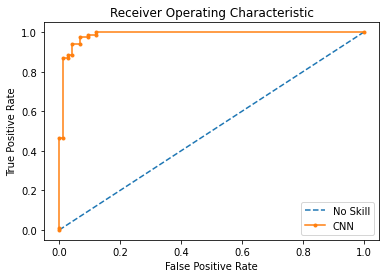

0.9869578881206789
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0269 - acc: 0.9896 - precision_m: 0.9938 - recall_m: 0.9904 - f1_m: 0.9918 - val_loss: 1.3918 - val_acc: 0.6840 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0015 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7139 - val_acc: 0.5417 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 5.6375e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.2595 - val_acc: 0.4861 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 1.7393e-04 - acc: 1.0000 - precision

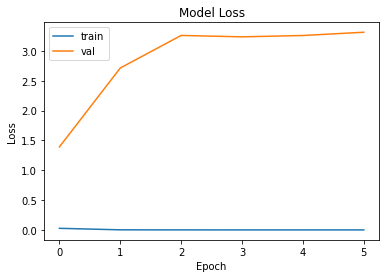

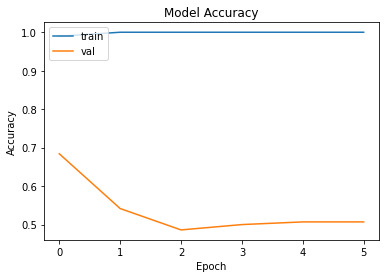

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.985


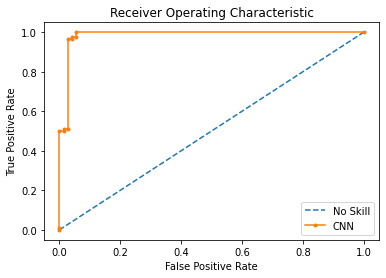

0.985479797979798
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0060 - acc: 0.9983 - precision_m: 0.9989 - recall_m: 0.9987 - f1_m: 0.9988 - val_loss: 2.7069 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0065 - acc: 0.9974 - precision_m: 0.9976 - recall_m: 0.9981 - f1_m: 0.9978 - val_loss: 3.5057 - val_acc: 0.4340 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 4.4214e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.5326 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 42s 36ms/step - loss: 1.4214e-04 - acc: 1.0000 - precision_

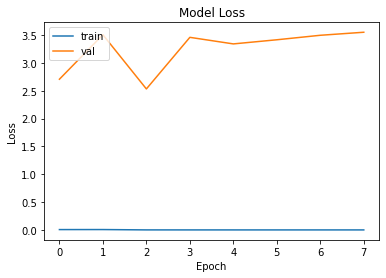

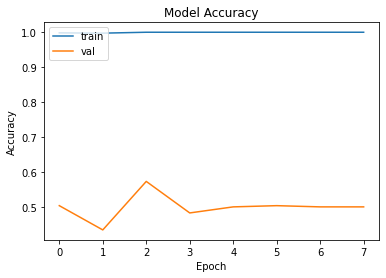

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.971


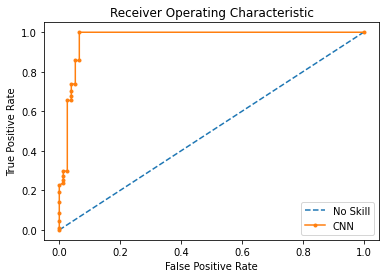

0.9707863408521303
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 3.4838e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7204 - val_acc: 0.5486 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 1.5920e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.9465 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 7.7608e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.1992 - val_acc: 0.5174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 5.8092e-05 - acc: 1.0000 - p

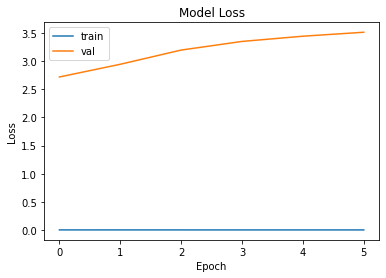

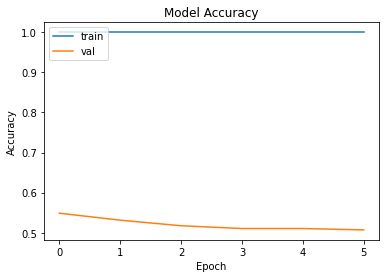

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.980


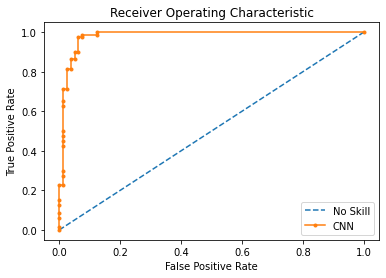

0.98046875
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 1.3756e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.8596 - val_acc: 0.5660 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 36ms/step - loss: 8.1219e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.0262 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 6.2198e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.1457 - val_acc: 0.5486 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 4.9185e-05 - acc: 1.0000 - precision

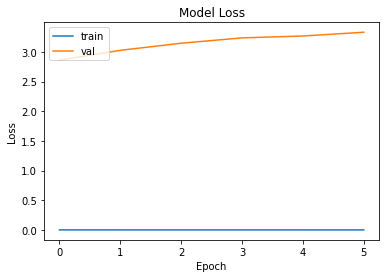

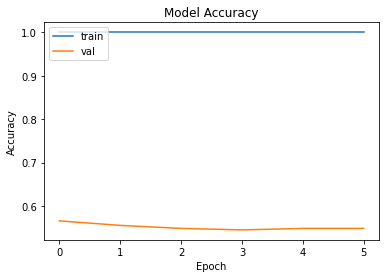

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.972


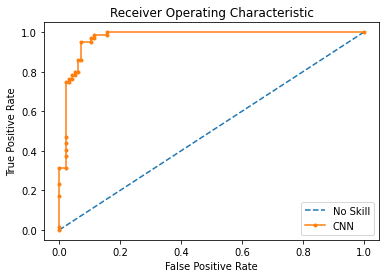

0.9723307291666666
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 8.5830e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.2334 - val_acc: 0.5208 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 36ms/step - loss: 6.6516e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.4167 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 4.8424e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.5123 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 4.1646e-05 - acc: 1.0000 - p

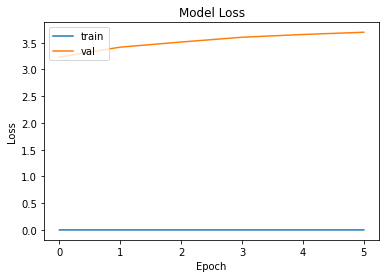

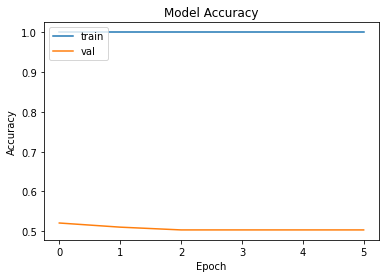

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.972


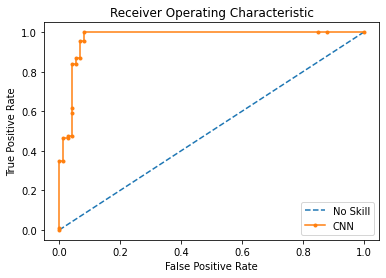

0.9723444374607165
[0.47377654558476945, 0.8999999999999998, 0.7450546622276306, 0.7499077153205871, 0.7410540360212325]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D())
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **CNN-BiLSTM with WE (Word2Vec)**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 780, 128)          192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 390, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 390, 128)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

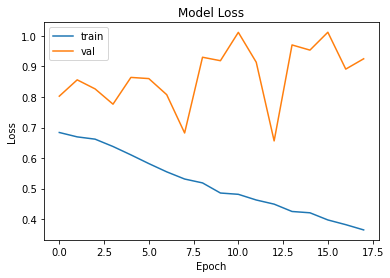

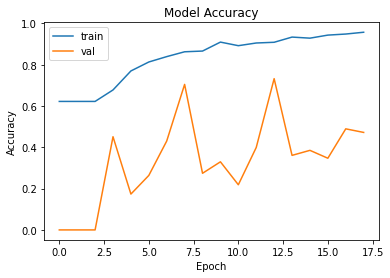

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.863


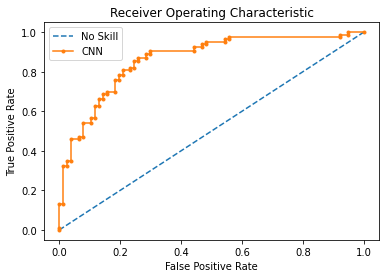

0.862775778438429
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.4425 - acc: 0.9080 - precision_m: 0.9174 - recall_m: 0.9449 - f1_m: 0.9271 - val_loss: 0.8207 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.4171 - acc: 0.9297 - precision_m: 0.9352 - recall_m: 0.9497 - f1_m: 0.9404 - val_loss: 0.9863 - val_acc: 0.3576 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.4072 - acc: 0.9332 - precision_m: 0.9391 - recall_m: 0.9562 - f1_m: 0.9457 - val_loss: 1.0566 - val_acc: 0.2986 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.3929 - acc: 0.9401 - precision_m: 0.942

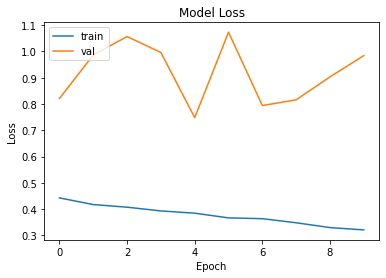

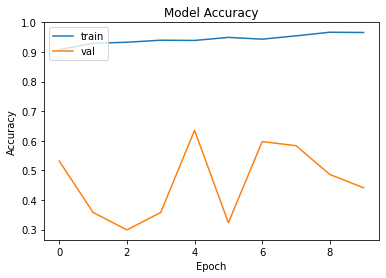

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.920


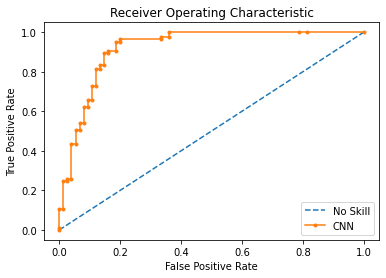

0.920156862745098
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3634 - acc: 0.9531 - precision_m: 0.9521 - recall_m: 0.9736 - f1_m: 0.9617 - val_loss: 0.9620 - val_acc: 0.4410 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3731 - acc: 0.9349 - precision_m: 0.9415 - recall_m: 0.9599 - f1_m: 0.9482 - val_loss: 1.1851 - val_acc: 0.2639 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.4046 - acc: 0.8924 - precision_m: 0.9169 - recall_m: 0.9311 - f1_m: 0.9163 - val_loss: 0.7292 - val_acc: 0.6667 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3440 - acc: 0.9514 - precision_m: 0.959

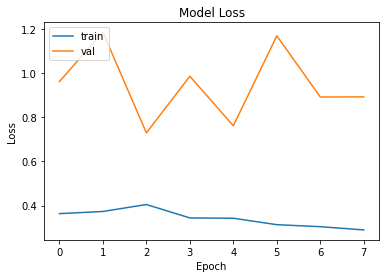

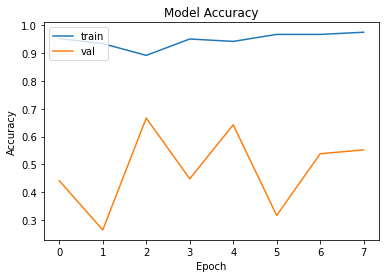

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.925


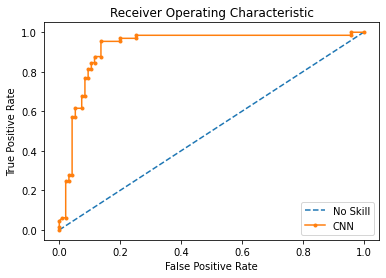

0.9246153846153846
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3483 - acc: 0.9462 - precision_m: 0.9451 - recall_m: 0.9693 - f1_m: 0.9562 - val_loss: 1.0883 - val_acc: 0.3438 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.3590 - acc: 0.9262 - precision_m: 0.9446 - recall_m: 0.9426 - f1_m: 0.9399 - val_loss: 1.0562 - val_acc: 0.3993 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3253 - acc: 0.9583 - precision_m: 0.9571 - recall_m: 0.9796 - f1_m: 0.9673 - val_loss: 0.8871 - val_acc: 0.5312 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.3065 - acc: 0.9679 - precision_m: 0.96

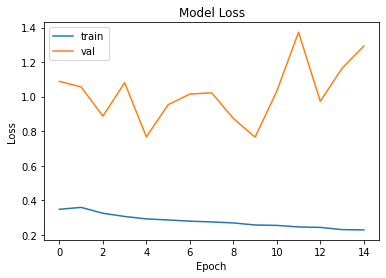

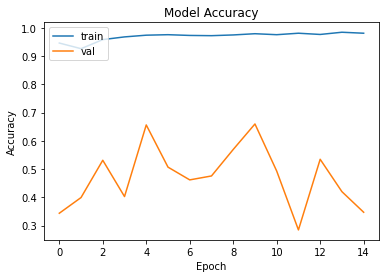

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.943


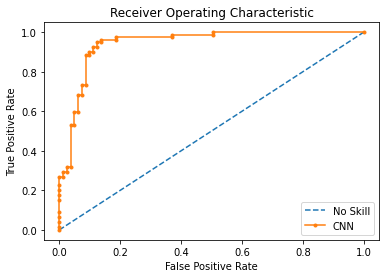

0.943272386310361
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2611 - acc: 0.9705 - precision_m: 0.9737 - recall_m: 0.9809 - f1_m: 0.9766 - val_loss: 0.8758 - val_acc: 0.5799 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2563 - acc: 0.9722 - precision_m: 0.9728 - recall_m: 0.9830 - f1_m: 0.9773 - val_loss: 0.9848 - val_acc: 0.5139 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2520 - acc: 0.9731 - precision_m: 0.9734 - recall_m: 0.9831 - f1_m: 0.9777 - val_loss: 0.9731 - val_acc: 0.5208 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2428 - acc: 0.9748 - precision_m: 0.977

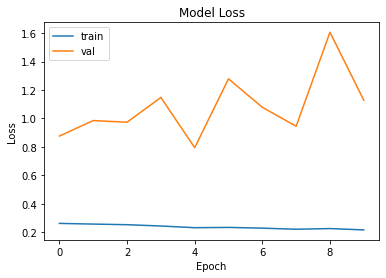

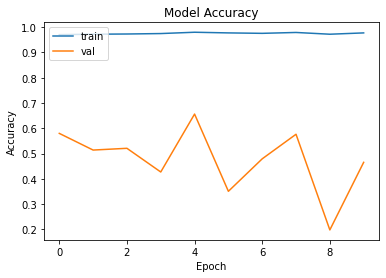

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.961


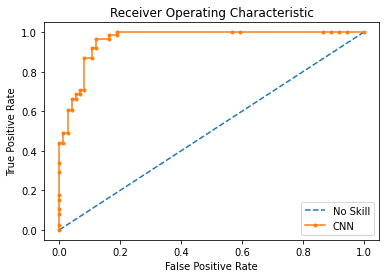

0.9611879321181647
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2304 - acc: 0.9774 - precision_m: 0.9790 - recall_m: 0.9860 - f1_m: 0.9820 - val_loss: 1.1352 - val_acc: 0.4479 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2240 - acc: 0.9766 - precision_m: 0.9772 - recall_m: 0.9848 - f1_m: 0.9807 - val_loss: 1.0167 - val_acc: 0.5139 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.2171 - acc: 0.9800 - precision_m: 0.9814 - recall_m: 0.9879 - f1_m: 0.9843 - val_loss: 0.8959 - val_acc: 0.5938 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2195 - acc: 0.9748 - precision_m: 0.97

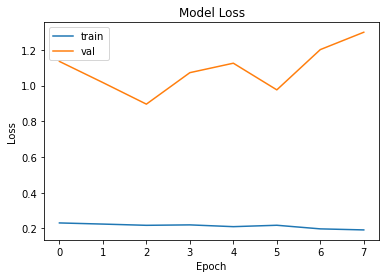

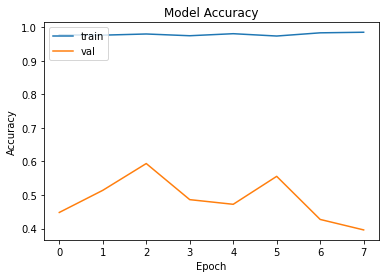

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.943


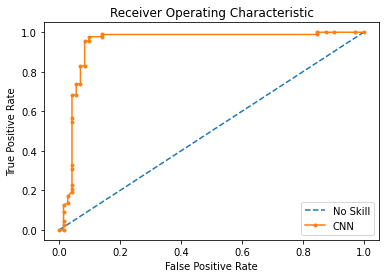

0.9426294191919191
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.2204 - acc: 0.9740 - precision_m: 0.9750 - recall_m: 0.9841 - f1_m: 0.9789 - val_loss: 1.1838 - val_acc: 0.4201 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2090 - acc: 0.9800 - precision_m: 0.9809 - recall_m: 0.9882 - f1_m: 0.9841 - val_loss: 1.3252 - val_acc: 0.3507 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2012 - acc: 0.9818 - precision_m: 0.9802 - recall_m: 0.9896 - f1_m: 0.9845 - val_loss: 0.7845 - val_acc: 0.6667 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.2164 - acc: 0.9688 - precision_m: 0.97

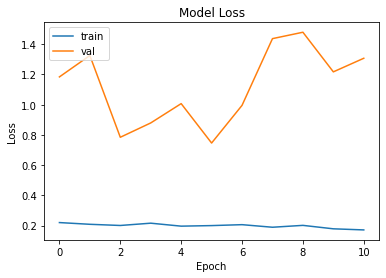

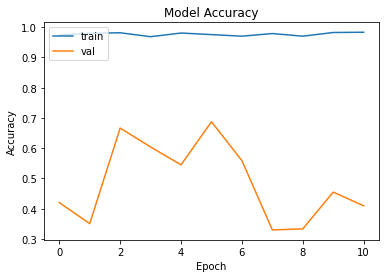

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.956


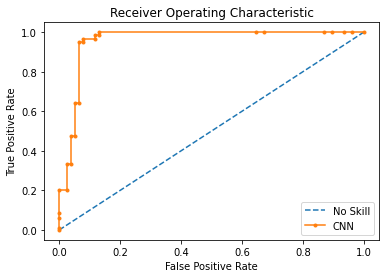

0.956453634085213
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1938 - acc: 0.9783 - precision_m: 0.9770 - recall_m: 0.9875 - f1_m: 0.9815 - val_loss: 0.9640 - val_acc: 0.5799 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1807 - acc: 0.9835 - precision_m: 0.9802 - recall_m: 0.9931 - f1_m: 0.9860 - val_loss: 1.0980 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.1754 - acc: 0.9861 - precision_m: 0.9853 - recall_m: 0.9930 - f1_m: 0.9889 - val_loss: 1.0544 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.1741 - acc: 0.9844 - precision_m: 0.985

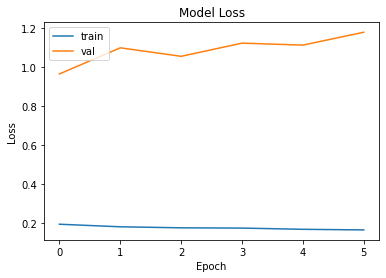

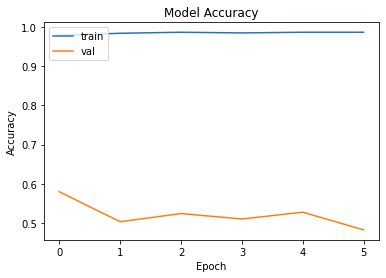

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.922


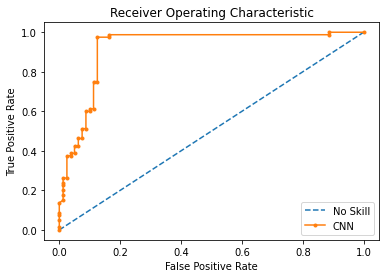

0.921640625
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1735 - acc: 0.9870 - precision_m: 0.9903 - recall_m: 0.9896 - f1_m: 0.9897 - val_loss: 1.2860 - val_acc: 0.4167 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1655 - acc: 0.9896 - precision_m: 0.9914 - recall_m: 0.9919 - f1_m: 0.9914 - val_loss: 1.2580 - val_acc: 0.4306 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.1618 - acc: 0.9896 - precision_m: 0.9919 - recall_m: 0.9920 - f1_m: 0.9919 - val_loss: 1.2172 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1584 - acc: 0.9896 - precision_m: 0.9919 - re

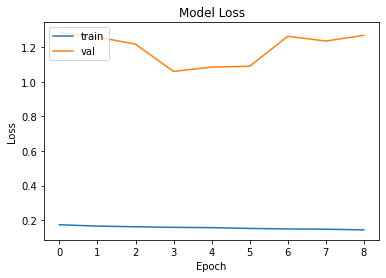

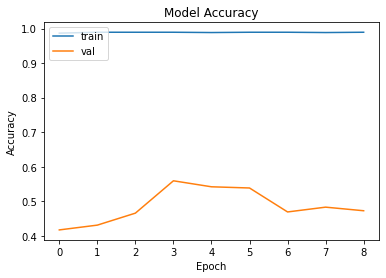

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.969


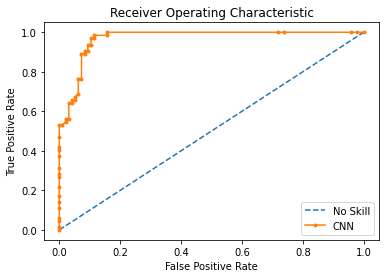

0.9689127604166666
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.1648 - acc: 0.9861 - precision_m: 0.9849 - recall_m: 0.9930 - f1_m: 0.9887 - val_loss: 0.7708 - val_acc: 0.6944 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.1680 - acc: 0.9818 - precision_m: 0.9809 - recall_m: 0.9901 - f1_m: 0.9850 - val_loss: 0.9961 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.1631 - acc: 0.9818 - precision_m: 0.9827 - recall_m: 0.9867 - f1_m: 0.9844 - val_loss: 0.9045 - val_acc: 0.6285 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.1606 - acc: 0.9835 - precision_m: 0.98

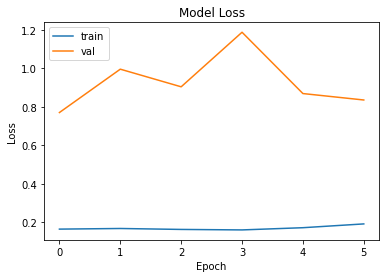

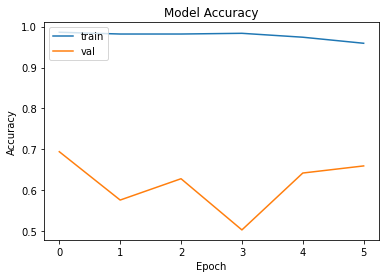

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.903


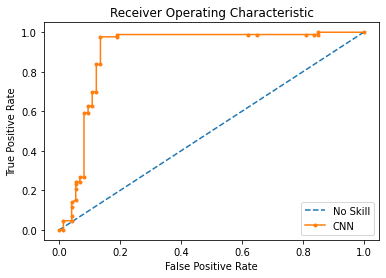

0.90328409805154
[0.38525547340512273, 0.884375, 0.7448679739236832, 0.7369443869590759, 0.7336222660541534]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size-1, embedding_dim, input_length=maxlen, trainable=False, weights=[embedding_matrix_word]))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D())
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **CNN-BiLSTM with WE (GloVe)**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 784, 300)          2227500   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 780, 128)          192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 390, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 390, 128)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

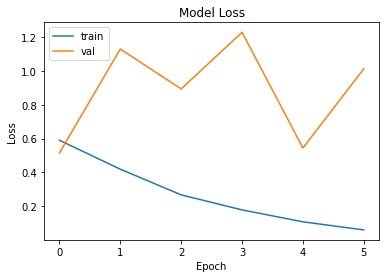

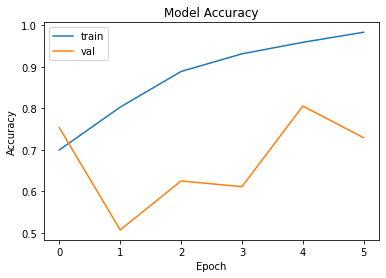

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.828


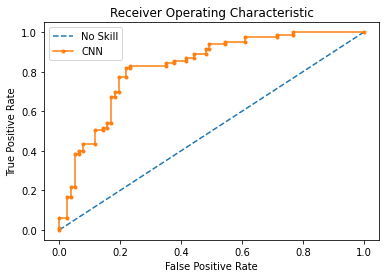

0.8277264903770928
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 43s 37ms/step - loss: 0.4563 - acc: 0.7882 - precision_m: 0.8186 - recall_m: 0.8708 - f1_m: 0.8298 - val_loss: 1.0753 - val_acc: 0.4236 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 37ms/step - loss: 0.3202 - acc: 0.8802 - precision_m: 0.8944 - recall_m: 0.9208 - f1_m: 0.9047 - val_loss: 0.5628 - val_acc: 0.7778 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.2415 - acc: 0.9028 - precision_m: 0.9151 - recall_m: 0.9351 - f1_m: 0.9205 - val_loss: 1.5250 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.2208 - acc: 0.9141 - precision_m: 0.92

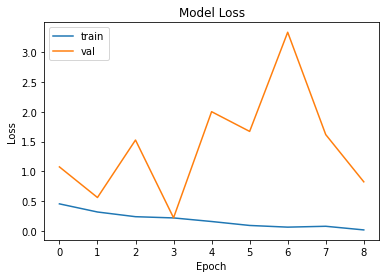

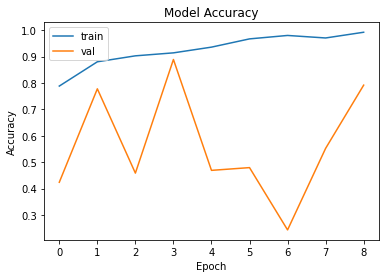

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.897


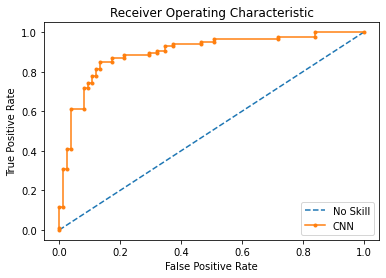

0.8972549019607843
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.2107 - acc: 0.9184 - precision_m: 0.9324 - recall_m: 0.9450 - f1_m: 0.9344 - val_loss: 1.6333 - val_acc: 0.4653 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1014 - acc: 0.9644 - precision_m: 0.9728 - recall_m: 0.9703 - f1_m: 0.9706 - val_loss: 1.7045 - val_acc: 0.4757 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0655 - acc: 0.9800 - precision_m: 0.9823 - recall_m: 0.9875 - f1_m: 0.9844 - val_loss: 1.7673 - val_acc: 0.5069 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0358 - acc: 0.9896 - precision_m: 0.99

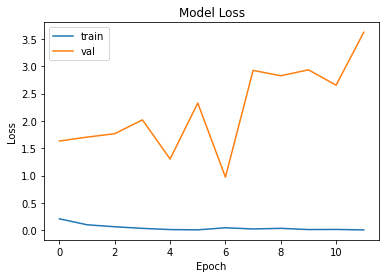

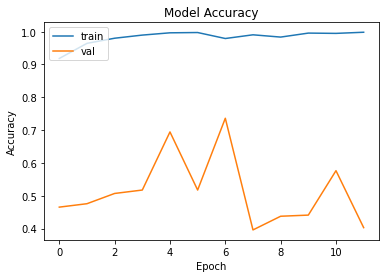

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.935


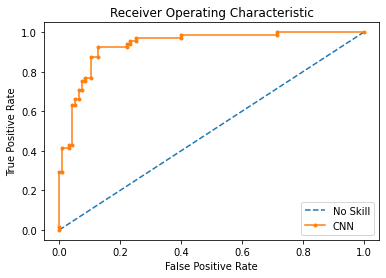

0.9353846153846155
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0587 - acc: 0.9800 - precision_m: 0.9846 - recall_m: 0.9830 - f1_m: 0.9834 - val_loss: 1.2454 - val_acc: 0.6493 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0275 - acc: 0.9896 - precision_m: 0.9947 - recall_m: 0.9884 - f1_m: 0.9912 - val_loss: 2.6879 - val_acc: 0.4583 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1133 - acc: 0.9575 - precision_m: 0.9660 - recall_m: 0.9732 - f1_m: 0.9669 - val_loss: 1.0558 - val_acc: 0.6632 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0255 - acc: 0.9887 - precision_m: 0.99

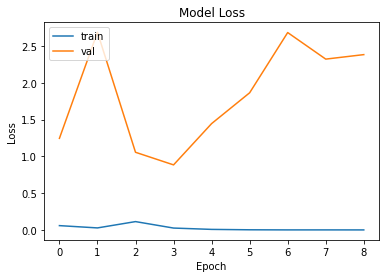

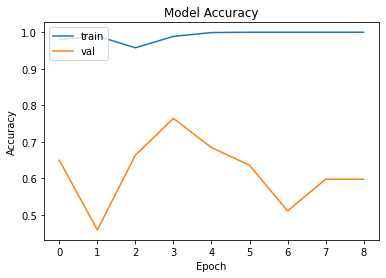

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.963


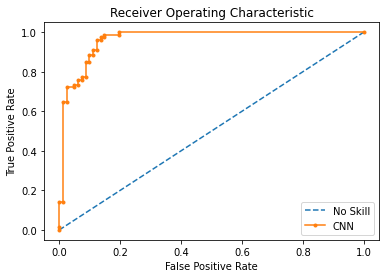

0.9632755117987186
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0160 - acc: 0.9965 - precision_m: 0.9971 - recall_m: 0.9969 - f1_m: 0.9969 - val_loss: 2.1434 - val_acc: 0.5660 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0165 - acc: 0.9957 - precision_m: 0.9965 - recall_m: 0.9973 - f1_m: 0.9968 - val_loss: 1.5370 - val_acc: 0.6562 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0043 - acc: 0.9991 - precision_m: 0.9985 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 2.4532 - val_acc: 0.5243 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 8.9307e-04 - acc: 1.0000 - precision_m: 

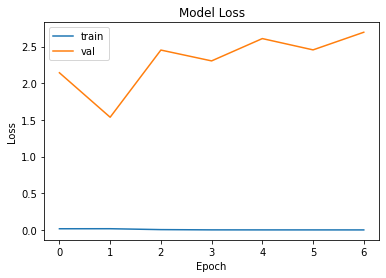

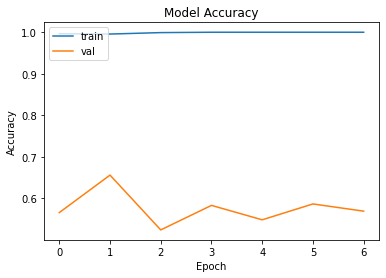

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.984


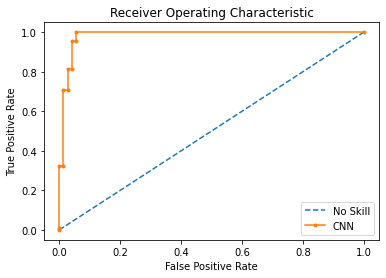

0.9838152105593966
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0039 - acc: 0.9983 - precision_m: 0.9983 - recall_m: 0.9987 - f1_m: 0.9985 - val_loss: 1.8979 - val_acc: 0.6076 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0020 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.6997 - val_acc: 0.5208 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 7.1742e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.0688 - val_acc: 0.5035 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0011 - acc: 1.0000 - precision_m: 

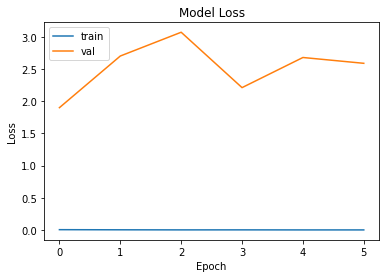

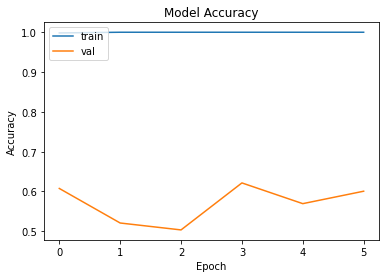

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.985


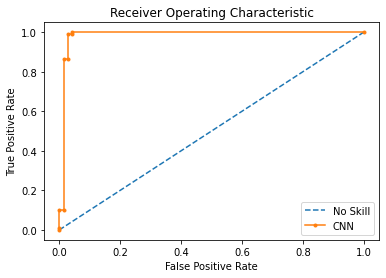

0.985479797979798
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0020 - acc: 0.9991 - precision_m: 1.0000 - recall_m: 0.9987 - f1_m: 0.9993 - val_loss: 3.6664 - val_acc: 0.3924 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0125 - acc: 0.9957 - precision_m: 0.9974 - recall_m: 0.9955 - f1_m: 0.9963 - val_loss: 1.4020 - val_acc: 0.6875 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0032 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.9891 - val_acc: 0.6424 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0429 - acc: 0.9844 - precision_m: 0.984

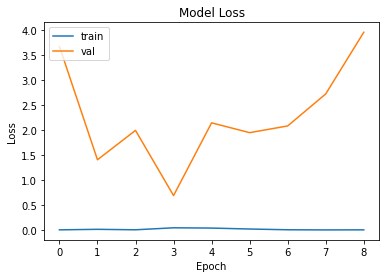

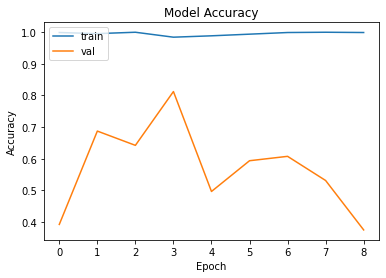

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.981


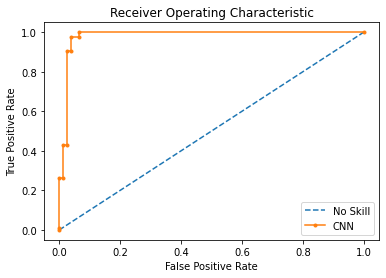

0.9808897243107769
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0148 - acc: 0.9948 - precision_m: 0.9960 - recall_m: 0.9953 - f1_m: 0.9955 - val_loss: 0.9714 - val_acc: 0.7847 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0070 - acc: 0.9983 - precision_m: 0.9986 - recall_m: 0.9988 - f1_m: 0.9987 - val_loss: 1.8761 - val_acc: 0.6667 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0015 - acc: 0.9991 - precision_m: 0.9985 - recall_m: 1.0000 - f1_m: 0.9992 - val_loss: 1.6961 - val_acc: 0.7188 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.0027 - acc: 0.9983 - precision_m: 1.00

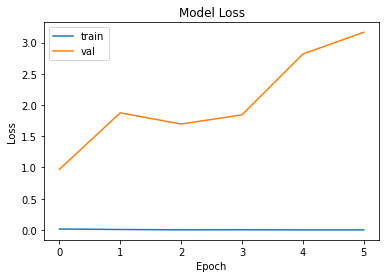

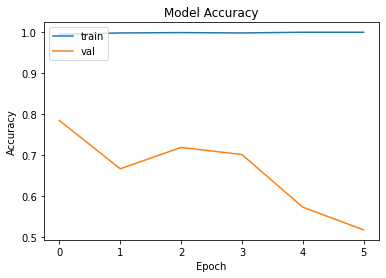

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.959


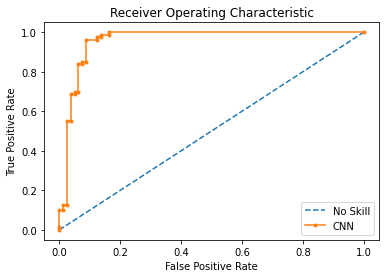

0.95859375
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0042 - acc: 0.9991 - precision_m: 0.9986 - recall_m: 1.0000 - f1_m: 0.9993 - val_loss: 2.5375 - val_acc: 0.5104 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0016 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.5075 - val_acc: 0.7188 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0020 - acc: 0.9991 - precision_m: 0.9987 - recall_m: 1.0000 - f1_m: 0.9994 - val_loss: 2.8470 - val_acc: 0.5521 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 35ms/step - loss: 2.9165e-04 - acc: 1.0000 - precision_m: 1.0000 -

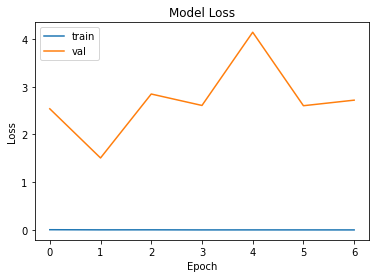

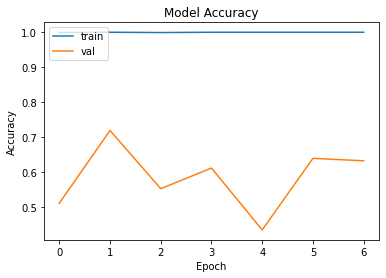

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.975


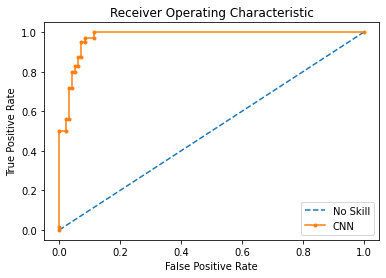

0.9754231770833333
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0132 - acc: 0.9948 - precision_m: 0.9958 - recall_m: 0.9959 - f1_m: 0.9957 - val_loss: 2.1711 - val_acc: 0.5972 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0084 - acc: 0.9974 - precision_m: 0.9962 - recall_m: 1.0000 - f1_m: 0.9980 - val_loss: 1.4321 - val_acc: 0.7222 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0263 - acc: 0.9905 - precision_m: 0.9925 - recall_m: 0.9911 - f1_m: 0.9914 - val_loss: 2.0468 - val_acc: 0.6076 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0166 - acc: 0.9948 - precision_m: 0.99

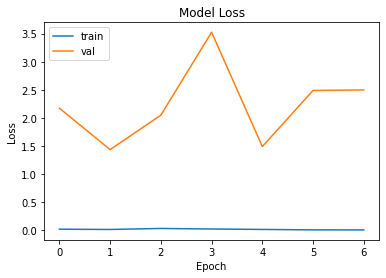

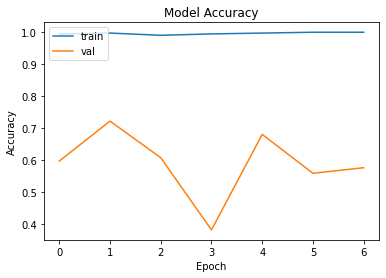

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.984


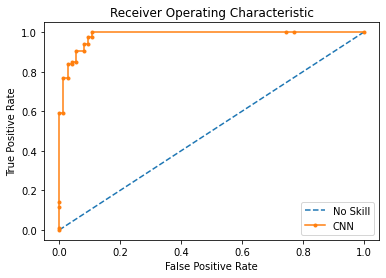

0.9835009428032684
[0.3688517542902263, 0.883125, 0.7372031760215758, 0.6985334956645965, 0.7062431716918944]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix_glove]))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D())
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)

#### **CNN-BiLSTM with WE (fastText)**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 784, 300)          2227200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 784, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 392, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 392, 128)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

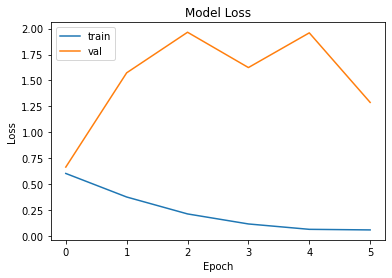

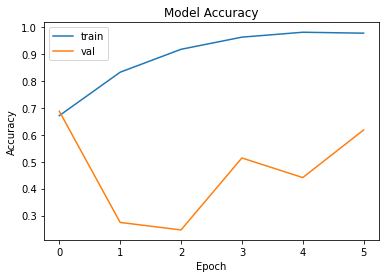

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.853


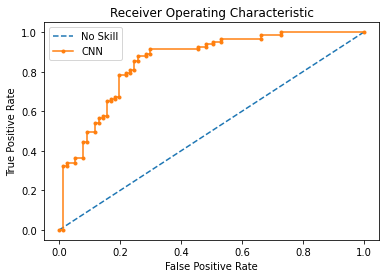

0.8533875762791425
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.3437 - acc: 0.8611 - precision_m: 0.8800 - recall_m: 0.9038 - f1_m: 0.8876 - val_loss: 0.8341 - val_acc: 0.6319 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 42s 37ms/step - loss: 0.1947 - acc: 0.9323 - precision_m: 0.9347 - recall_m: 0.9582 - f1_m: 0.9441 - val_loss: 0.5668 - val_acc: 0.7986 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 42s 37ms/step - loss: 0.1199 - acc: 0.9575 - precision_m: 0.9600 - recall_m: 0.9734 - f1_m: 0.9656 - val_loss: 1.5964 - val_acc: 0.4792 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 42s 36ms/step - loss: 0.0698 - acc: 0.9792 - precision_m: 0.98

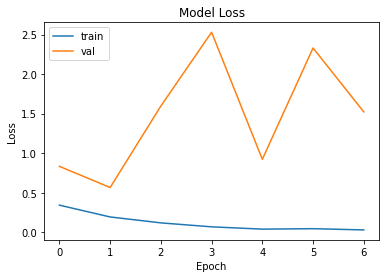

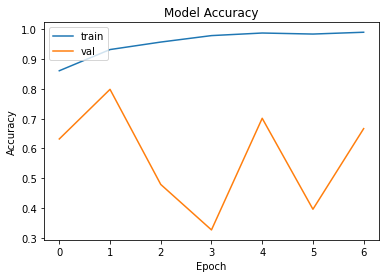

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.908


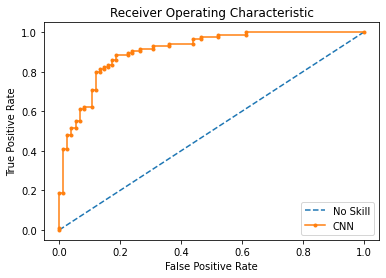

0.907607843137255
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1490 - acc: 0.9488 - precision_m: 0.9557 - recall_m: 0.9650 - f1_m: 0.9582 - val_loss: 1.2627 - val_acc: 0.5729 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 0.0707 - acc: 0.9792 - precision_m: 0.9849 - recall_m: 0.9822 - f1_m: 0.9831 - val_loss: 2.4986 - val_acc: 0.3403 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0465 - acc: 0.9852 - precision_m: 0.9883 - recall_m: 0.9899 - f1_m: 0.9888 - val_loss: 3.6499 - val_acc: 0.2153 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 36ms/step - loss: 0.1090 - acc: 0.9644 - precision_m: 0.972

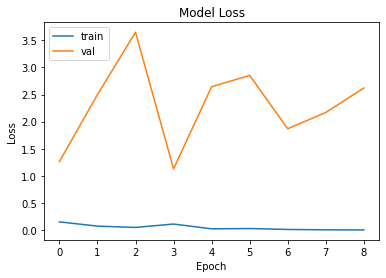

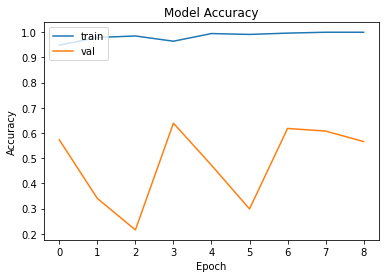

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.941


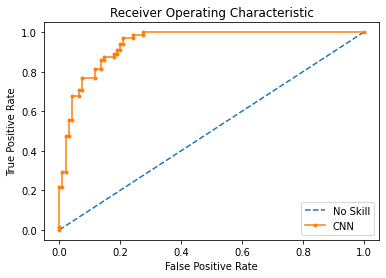

0.9410526315789475
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0551 - acc: 0.9835 - precision_m: 0.9853 - recall_m: 0.9887 - f1_m: 0.9865 - val_loss: 0.9946 - val_acc: 0.7083 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0274 - acc: 0.9931 - precision_m: 0.9918 - recall_m: 0.9977 - f1_m: 0.9946 - val_loss: 1.3150 - val_acc: 0.6840 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0035 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 1.8769 - val_acc: 0.6562 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0013 - acc: 0.9991 - precision_m: 0.99

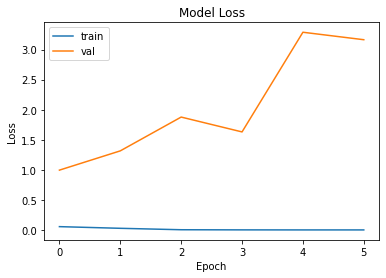

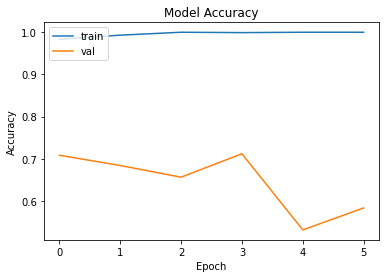

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.976


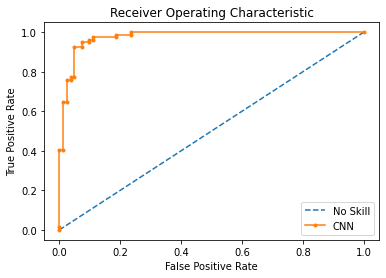

0.9764025629004532
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0503 - acc: 0.9844 - precision_m: 0.9848 - recall_m: 0.9907 - f1_m: 0.9873 - val_loss: 1.7749 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0316 - acc: 0.9913 - precision_m: 0.9905 - recall_m: 0.9955 - f1_m: 0.9928 - val_loss: 1.2754 - val_acc: 0.7014 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0152 - acc: 0.9957 - precision_m: 0.9981 - recall_m: 0.9947 - f1_m: 0.9963 - val_loss: 2.9285 - val_acc: 0.4097 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0048 - acc: 0.9991 - precision_m: 0.99

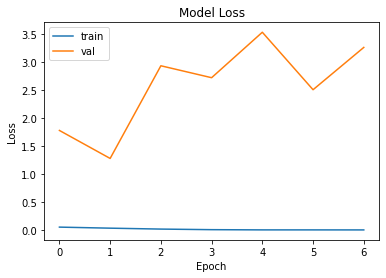

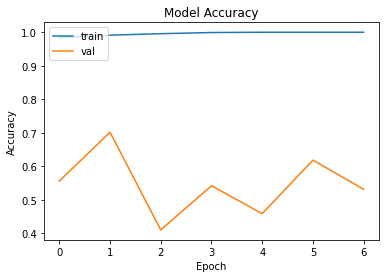

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.985


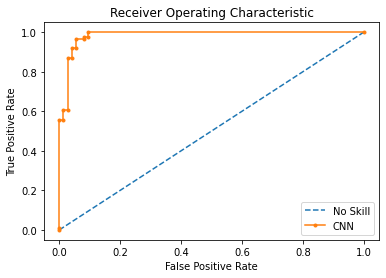

0.9846008799497171
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0220 - acc: 0.9939 - precision_m: 0.9935 - recall_m: 0.9973 - f1_m: 0.9952 - val_loss: 2.2268 - val_acc: 0.5347 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0074 - acc: 0.9983 - precision_m: 0.9987 - recall_m: 0.9988 - f1_m: 0.9987 - val_loss: 2.8458 - val_acc: 0.4826 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0028 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.8399 - val_acc: 0.5451 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 2.7232e-04 - acc: 1.0000 - precision_m: 

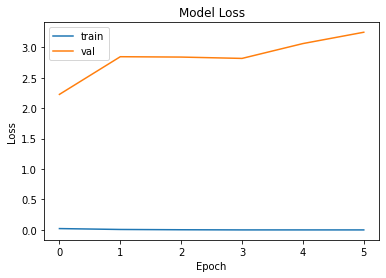

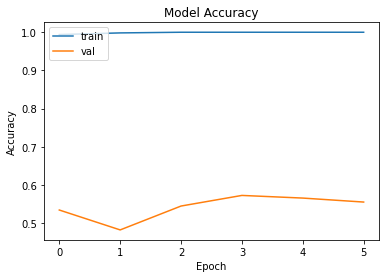

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.990


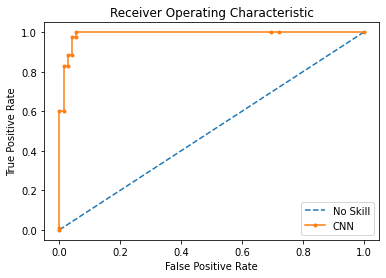

0.9902146464646464
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 0.0018 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.0499 - val_acc: 0.6250 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 41s 35ms/step - loss: 7.3939e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.3978 - val_acc: 0.6111 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 2.8134e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7091 - val_acc: 0.5833 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.5776e-04 - acc: 1.0000 - preci

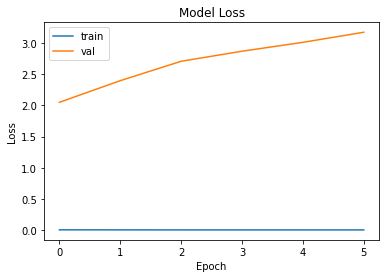

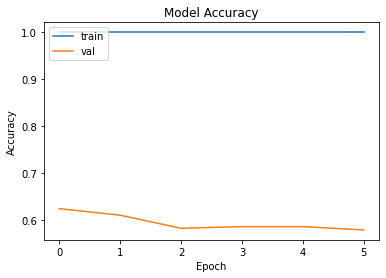

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.981


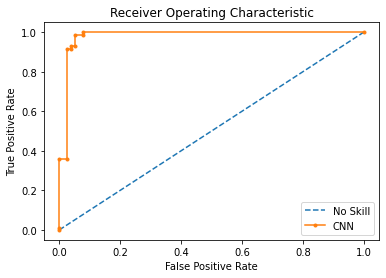

0.9807330827067668
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 5.7715e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.6669 - val_acc: 0.5556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 3.3127e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7068 - val_acc: 0.5799 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.6589e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.9446 - val_acc: 0.5764 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.0186e-04 - acc: 1.0000 - p

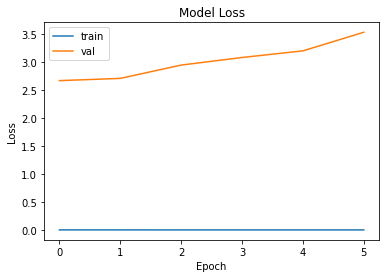

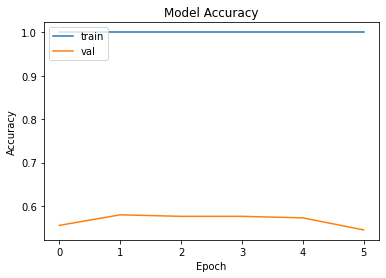

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.970


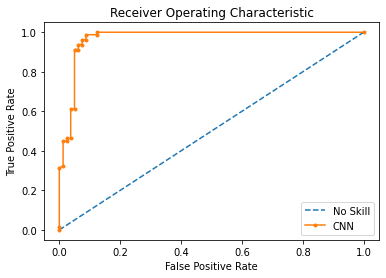

0.970234375
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 3.2827e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.6239 - val_acc: 0.6042 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.9003e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.7468 - val_acc: 0.6076 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.2515e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.9957 - val_acc: 0.5903 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 40s 35ms/step - loss: 6.1172e-05 - acc: 1.0000 - precisio

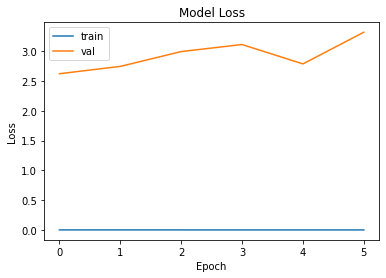

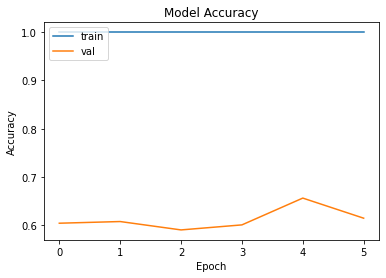

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.969


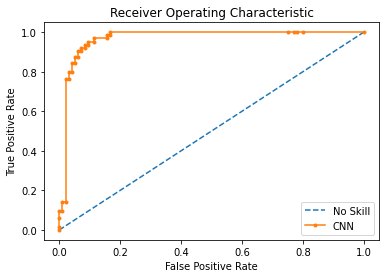

0.9692382812500001
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.9396e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 2.9820 - val_acc: 0.5694 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
1152/1152 [==============================] - 40s 35ms/step - loss: 1.2042e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.0097 - val_acc: 0.5972 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
1152/1152 [==============================] - 41s 35ms/step - loss: 6.0773e-05 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - val_loss: 3.2873 - val_acc: 0.5833 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/20
1152/1152 [==============================] - 41s 35ms/step - loss: 5.0913e-05 - acc: 1.0000 - p

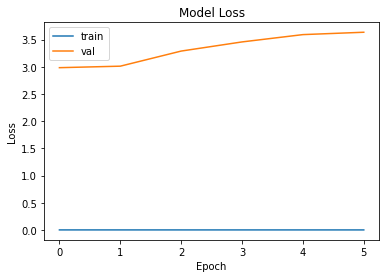

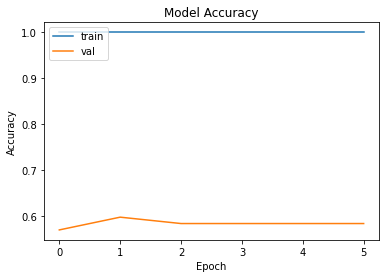

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.991


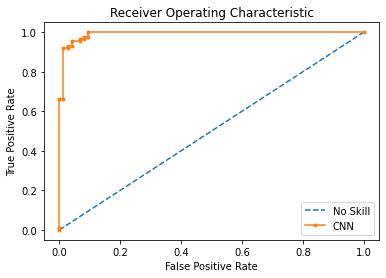

0.9913576367064739
[0.4521468523208023, 0.8831249999999999, 0.7300593709945679, 0.7261126494407654, 0.7191668909788131]


In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size-1, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix_fasttext]))
model.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
model.add(layers.MaxPooling1D())
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

k_fold_model(model)